# 0.0 IMPORTAR BIBLIOTECAS (Import Libraries)

In [1]:
import math
import numpy             as np
import pandas            as pd
import inflection
import datetime
import pickle
import json

import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb

from IPython.display       import Image
from IPython.core.display  import HTML
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn               import metrics as mt
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso



## 0.1 FUNÇÕES DE AJUDA (Helper Functions)

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
       
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values 
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) 
    kcorr = k - (k-1)**2/(n-1)                  
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1, rcorr-1) ) ) 


def mean_percentage_error(y, yhat):
    return np.mean(((y-yhat)/y))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))
    
    return pd. DataFrame({'Model Name': model_name , 
                          'MAE' : mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index= [0])



def cross_validation (x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)): 
        if verbose:
            print(f'\n KFold Number: {k}')
            
        # data inicial e data final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)  
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)


        # filtragem do conjunto de dados 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        # conjunto de dados de treinamento e validação 
        # treinamento
        xtraining = training.drop( ['date','sales'], axis =1)
        ytraining = training['sales']

        # validação
        xvalidation = validation.drop( ['date','sales'], axis =1)
        yvalidation = validation['sales']


        # treinamento do algoritmo
        # modelo
        m = model.fit(xtraining, ytraining)

        # predição
        yhat= m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # armazenamento do desempenho de cada iteração kfold
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales_raw = pd.read_csv('rossmann-store-sales/train.csv', low_memory = False)
df_store_raw = pd.read_csv('rossmann-store-sales/store.csv', low_memory = False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store') #df1, df2, tipo de ligação (semelhante sql), coluna que será feita ligação

# 1.0 - PASSO 01 (limpeza) - DATA DESCRIPTION (olhar de maneira geral os dados)
  

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimension

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval                  
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#fillna preenche os valores NA/NaN usando o metodo especificado
df1['promo_interval'].fillna(0, inplace=True) #fillna(valor a ser substituido, inplace=True ja substitui automaticamente os valores da coluna

df1['month_map'] = df1['date'].dt.month.map(month_map) 
#cria uma coluna month_map mapeando apenas os meses da coluna date (valor em numeros) pelo valor correspondente na lista month_map (valor em string)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis= 1)                                
# 1 - split foi usado para criar uma lista com valores que foram separados por ,  

# 2- criou a condicional que confere se o valor de month_map esta dentro da lista de promo_interval, SE sim = recebe 1, SENAO = recebe 0

# 3- Criou outra condicional que confere se o valor de promo_interval é 0, SE sim = recebe 0, SENAO = recebe a condicional 2 com valor recebido

# 4- aplicou o lambda para percorrer todas as linhas das colunas promo_interval e month_map do DF e executar a verificação, 
                                    #por ter mais de uma coluna é necessário usar o axis = 1 (define o sentido a percorrer = vertical)

# 5- criou uma nova coluna chamada is_promo onde guarda os valores gerados do código acima, mostrando se a loja está em promoção ou não


## 1.6 Change Types

In [11]:
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [13]:
#separar os dados numericos e dados categoricos

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std(desvio padrão), min, max, range(dif min-max), skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.8 Categorical Attirbutes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

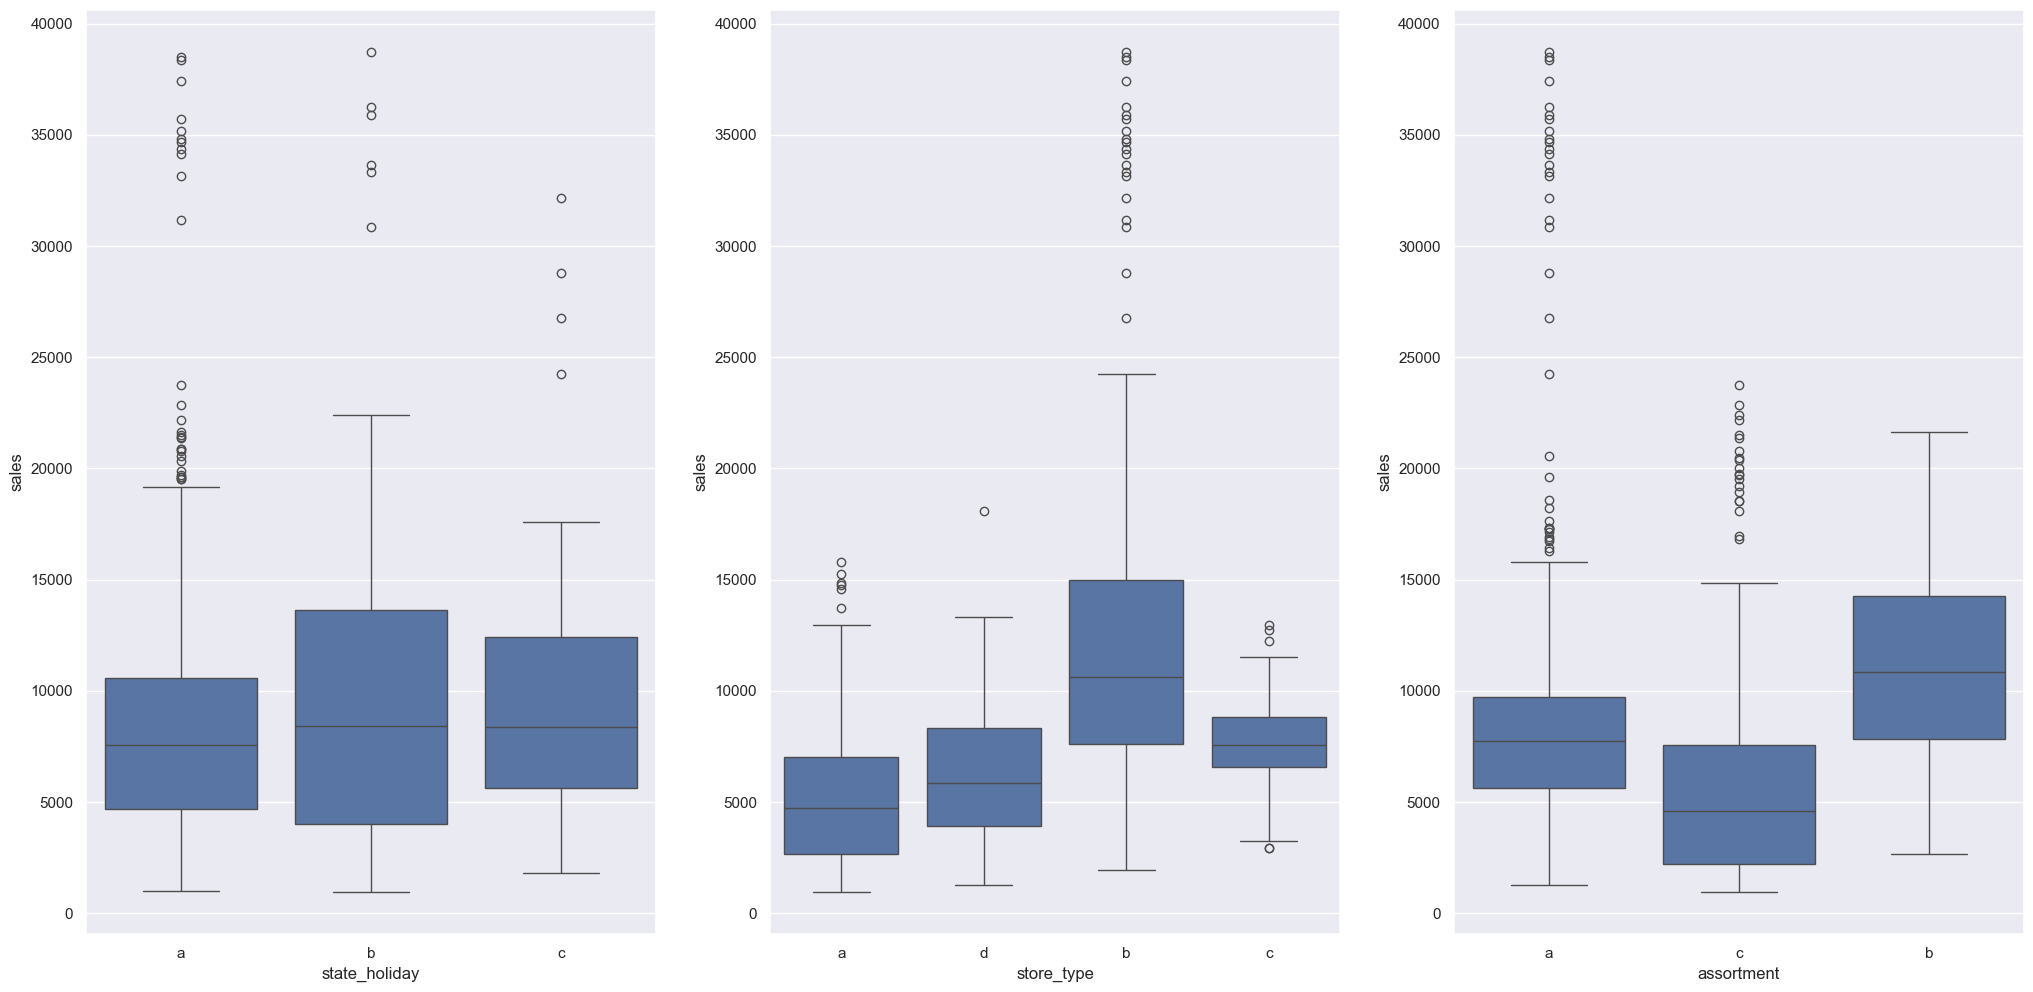

In [16]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0 - PASSO 02 (limpeza) - FEATURE ENGINEERING (deriva as variaveis a partir de variaveis originais)

## 2.0 - Mapa Mental de Hipoteses

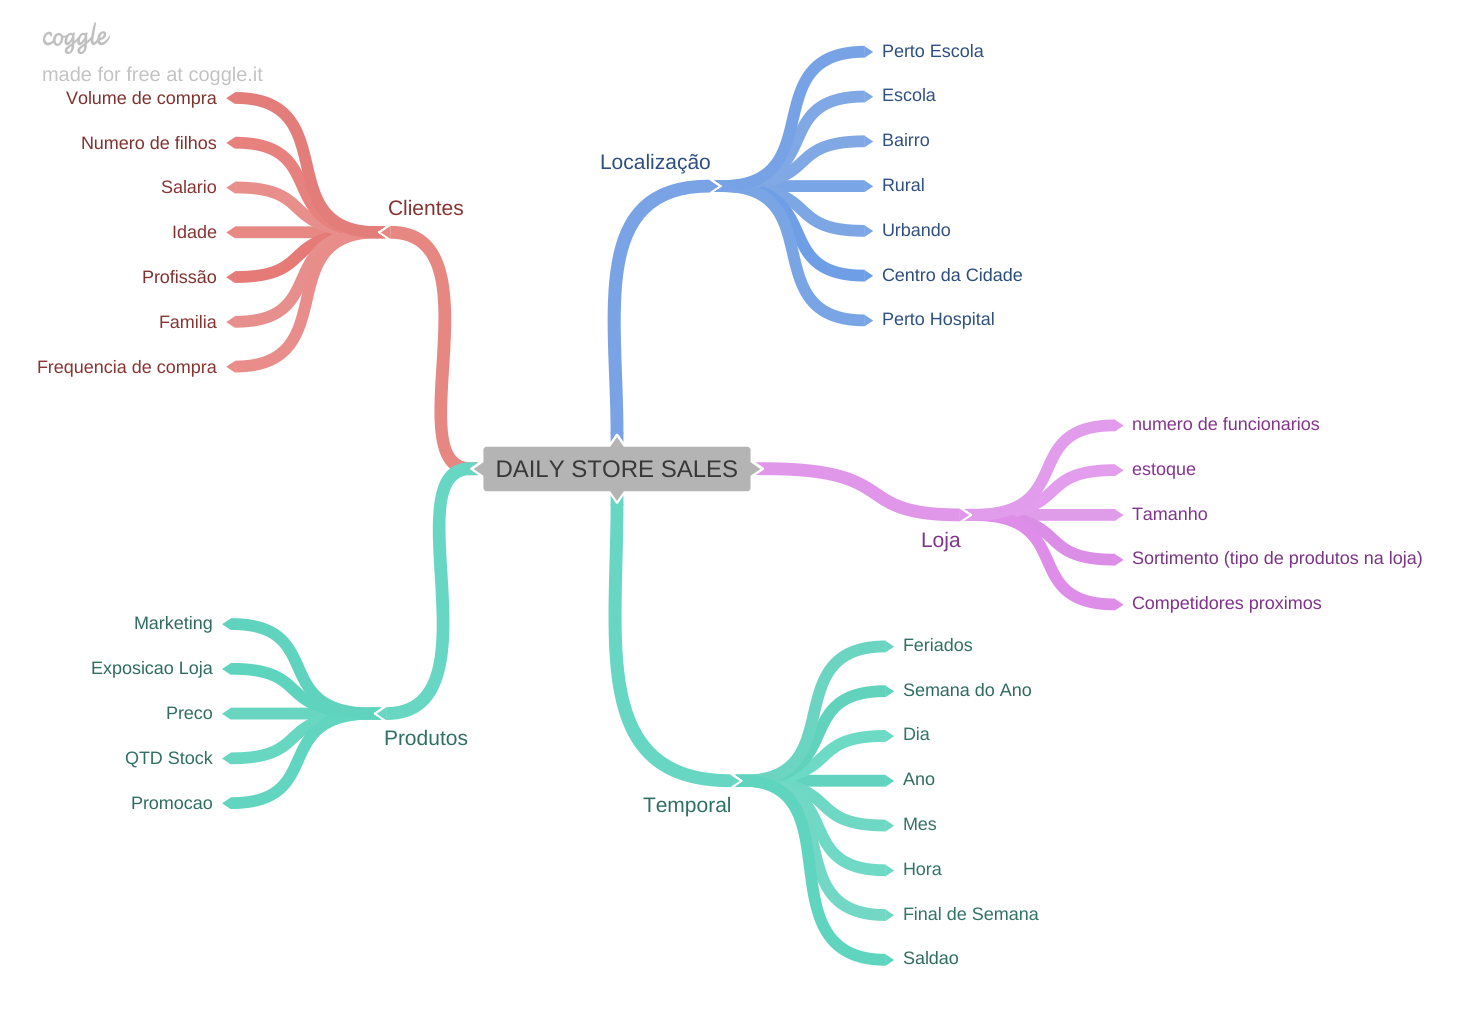

In [17]:
Image ('mindmap_hipoteses.png')

# fenomeno - o que quer saber, centro
# agentes - entidades que possam ter impacto no fenomeno (clientes(localização, etc)
# atributos - descrição dos agentes

## 2.1 - Criação das Hipoteses

### 2.1.1 - Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveram vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.


### 2.1.2 - Hipoteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo deveriam vender mais.


### 2.1.3 - Hipoteses Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.


## 2.2 - Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.**  Lojas com mais promoções consecutivas deveriam vender mais

**7.**  Lojas abertas durante o feriado de Natal deveriam vender mas.

**8.**  Lojas deveriam vender mais ao longo dos aos.

**9.**  Lojas deveriam vender mais no segundo semestre doano.

**10.**  Lojas deveriam vender mais depois do dia 10 de caa mês.

**11.**. Lojas deveriam vender menos aos finais d 
smana.

**12.**. Lojas deveriam vender menos durante os feriadosesco lares..



## 2.3 - Feature Engineering

In [18]:
df2 = df1.copy()


In [19]:
#variaves que serão derivadas

#year
df2['year'] = df2['date'].dt.year.astype('int64')

#month
df2['month'] = df2['date'].dt.month.astype('int64')

#day
df2['day'] = df2['date'].dt.day.astype('int64')

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

#year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'] , month =x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype('int64')


#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')




In [20]:
df2.dtypes#df2.head().T

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 - PASSO 03 (limpeza) - FILTRAGEM DE VARIÁVEIS 

In [21]:
df3 = df2.copy()


## 3.1 - Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] 

## 3.2 - Seleção das colunas

In [23]:
cols_drop = ['customers', 'open', 'month_map', 'promo_interval']
df3 = df3.drop(cols_drop, axis= 1)

In [24]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04 (exploração) - ANALISE EXPLORATORIA DOS DADOS

In [25]:
df4 = df3.copy()


## 4.1 - Analise Univariada


### 4.1.1 Response Variable

C:\Users\donoex\AppData\Local\Temp\ipykernel_8760\3772916294.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], kde = False)


<Axes: xlabel='sales'>

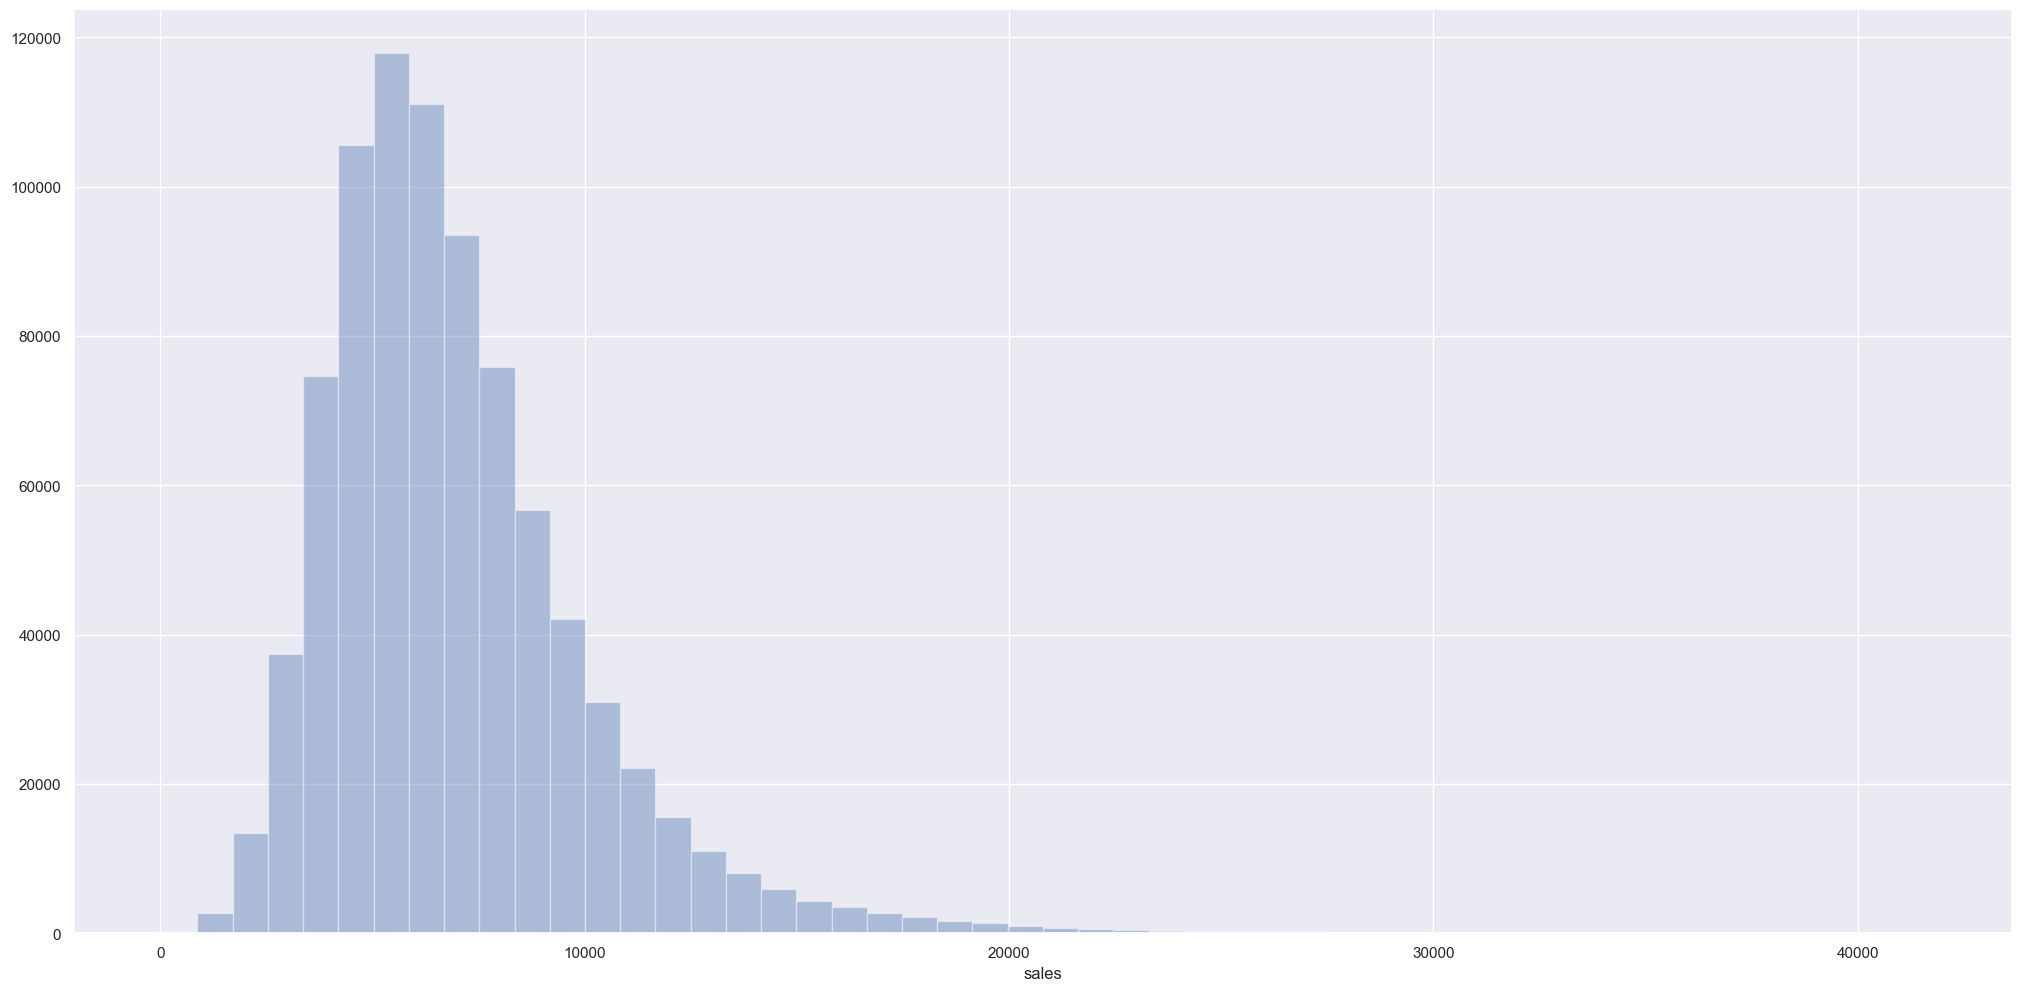

In [26]:
sns.distplot(df4['sales'], kde = False)

### 4.1.2 Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

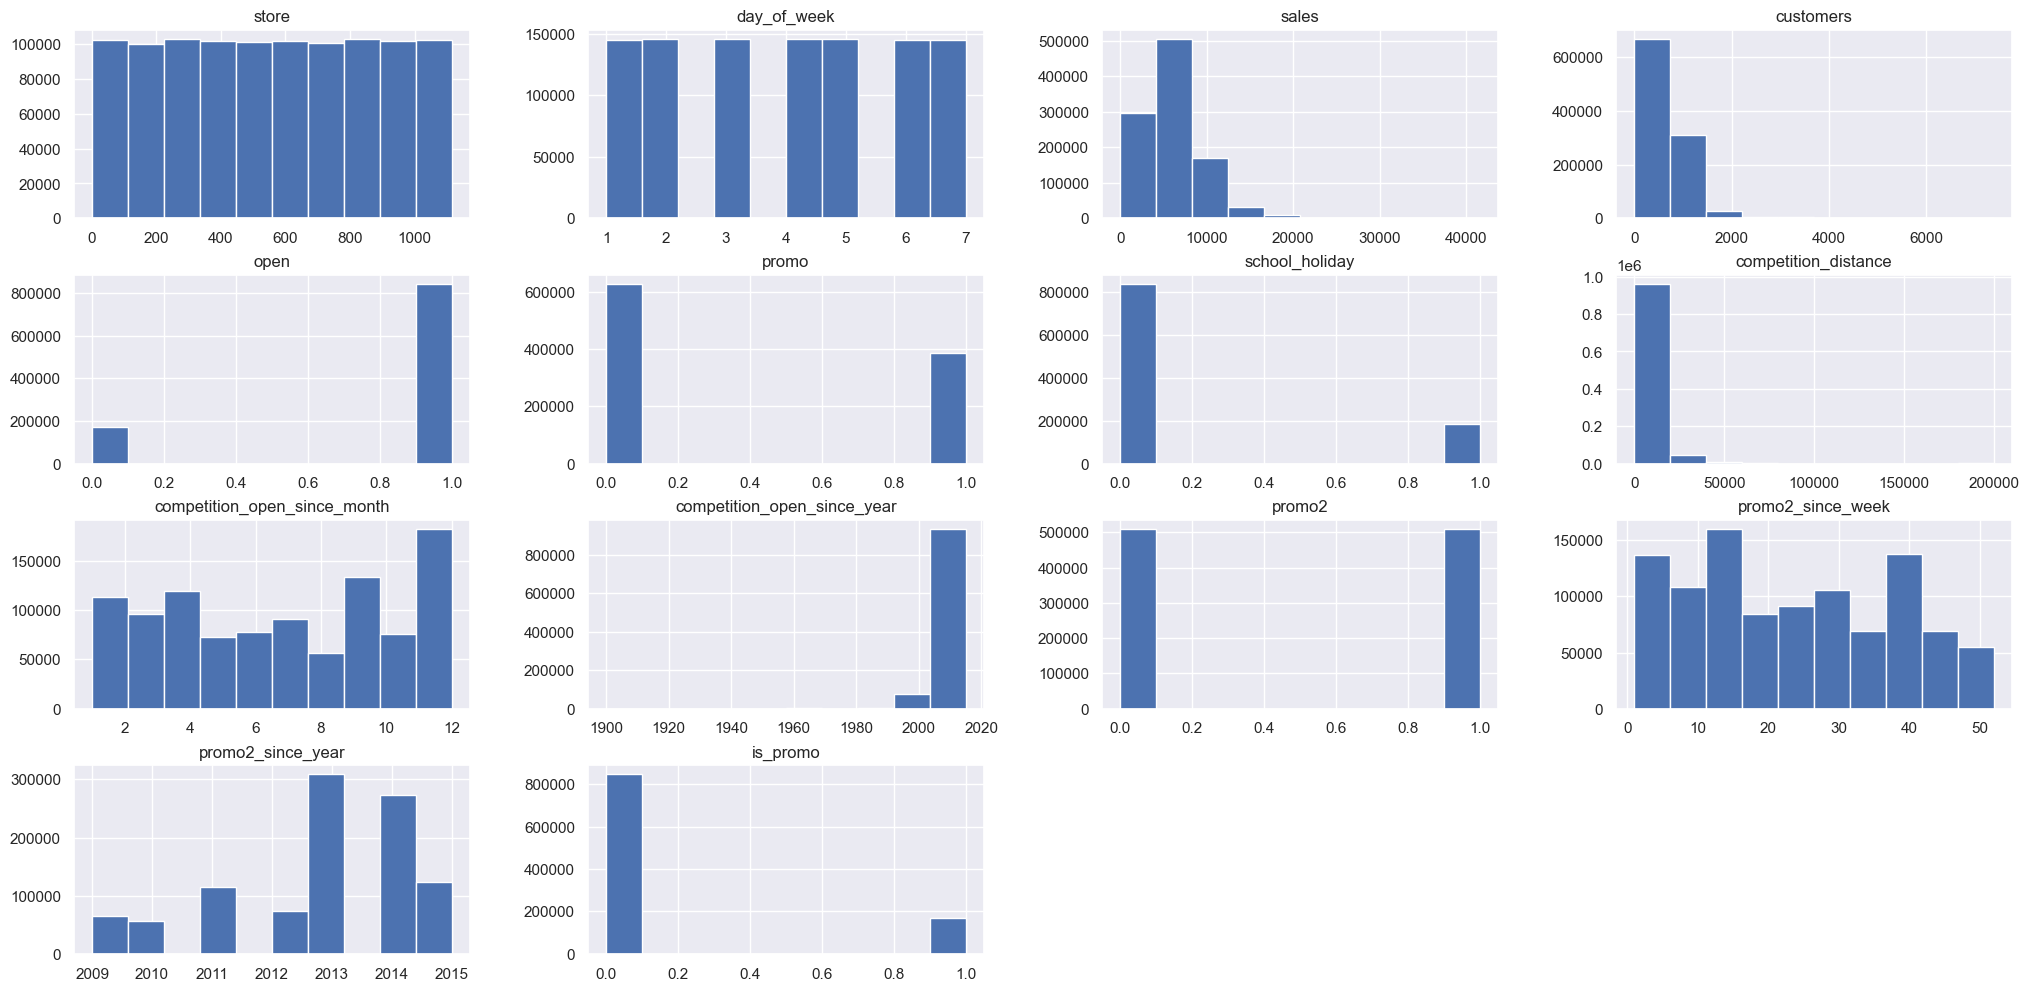

In [27]:
num_attributes.hist()

### 4.1.3 Categorical Variable

In [28]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [29]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [30]:
pip install --upgrade seaborn pandas

Note: you may need to restart the kernel to use updated packages.


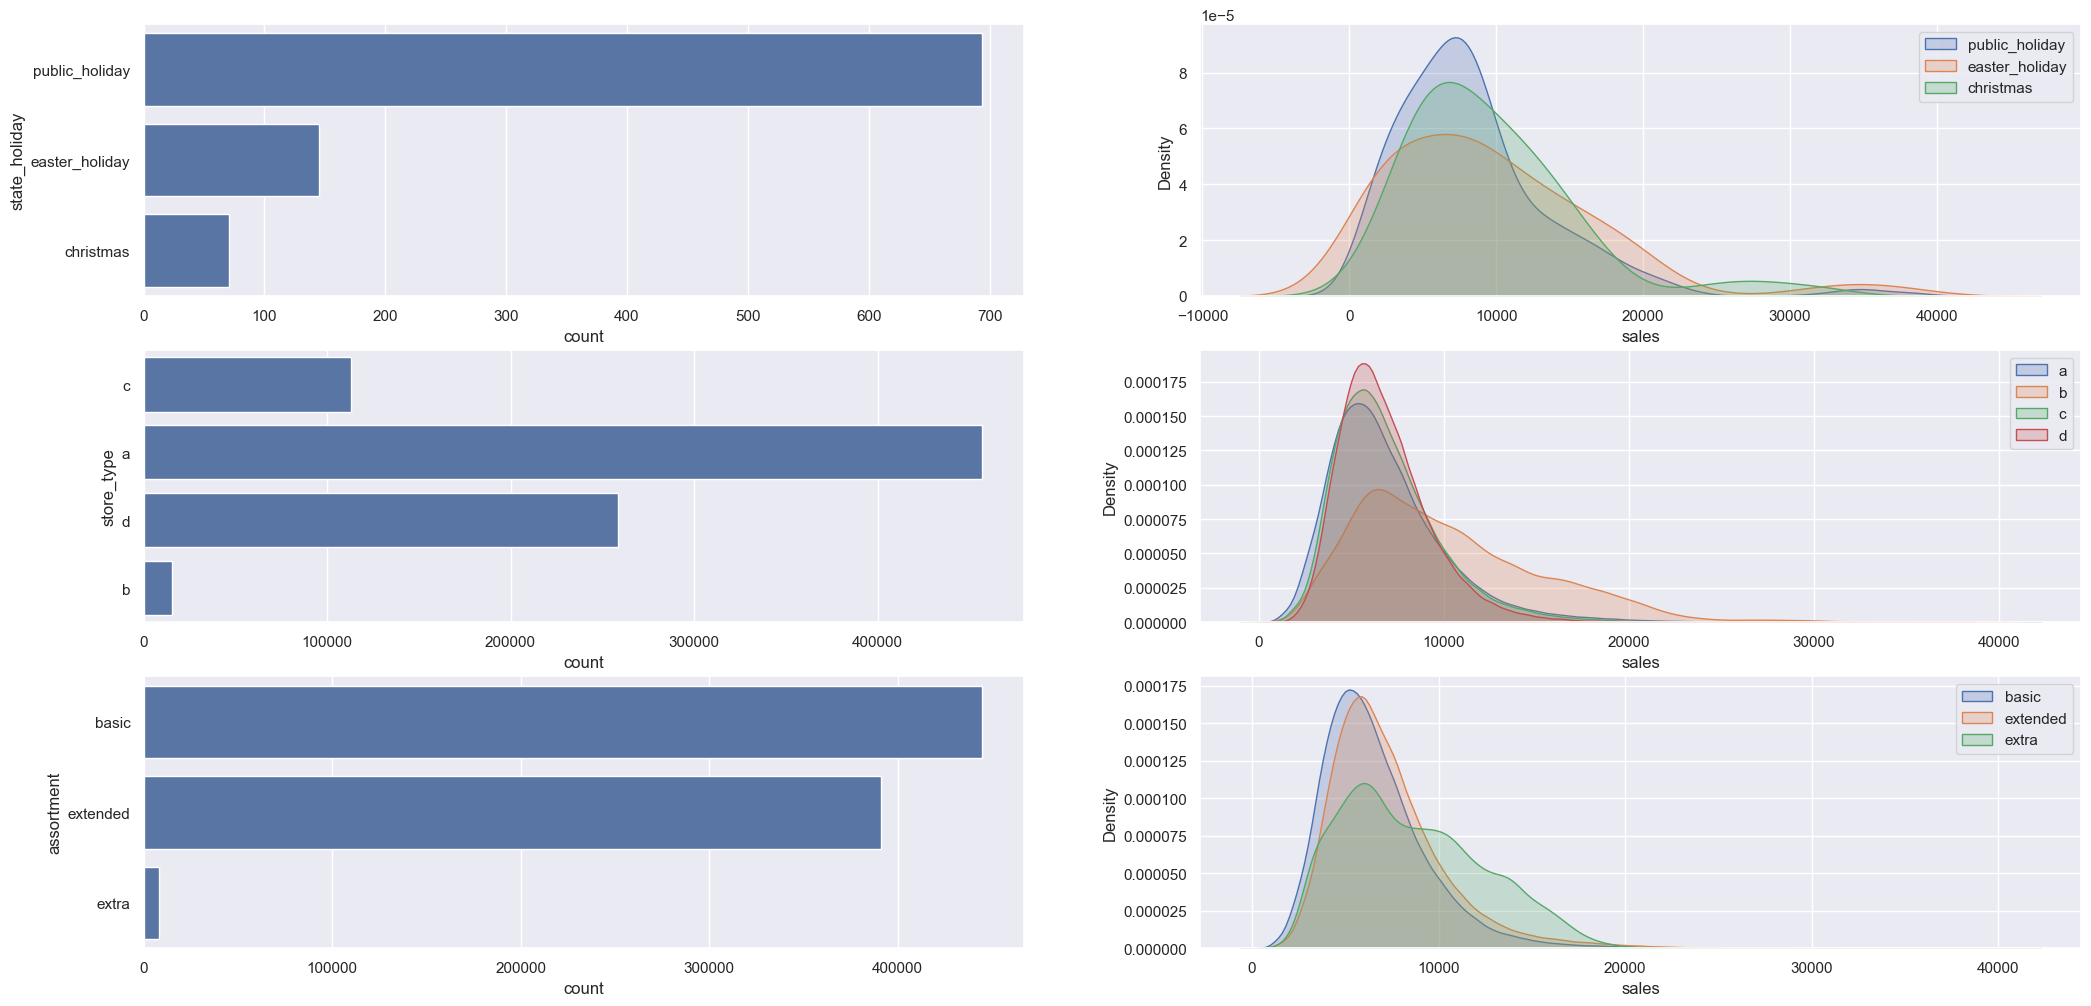

In [31]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill=True)
plt.legend()


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill=True)
plt.legend()



## 4.2 - Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
***FALSA*** Lojas com Maior Sortimento vendem menos.

<Axes: xlabel='year_week'>

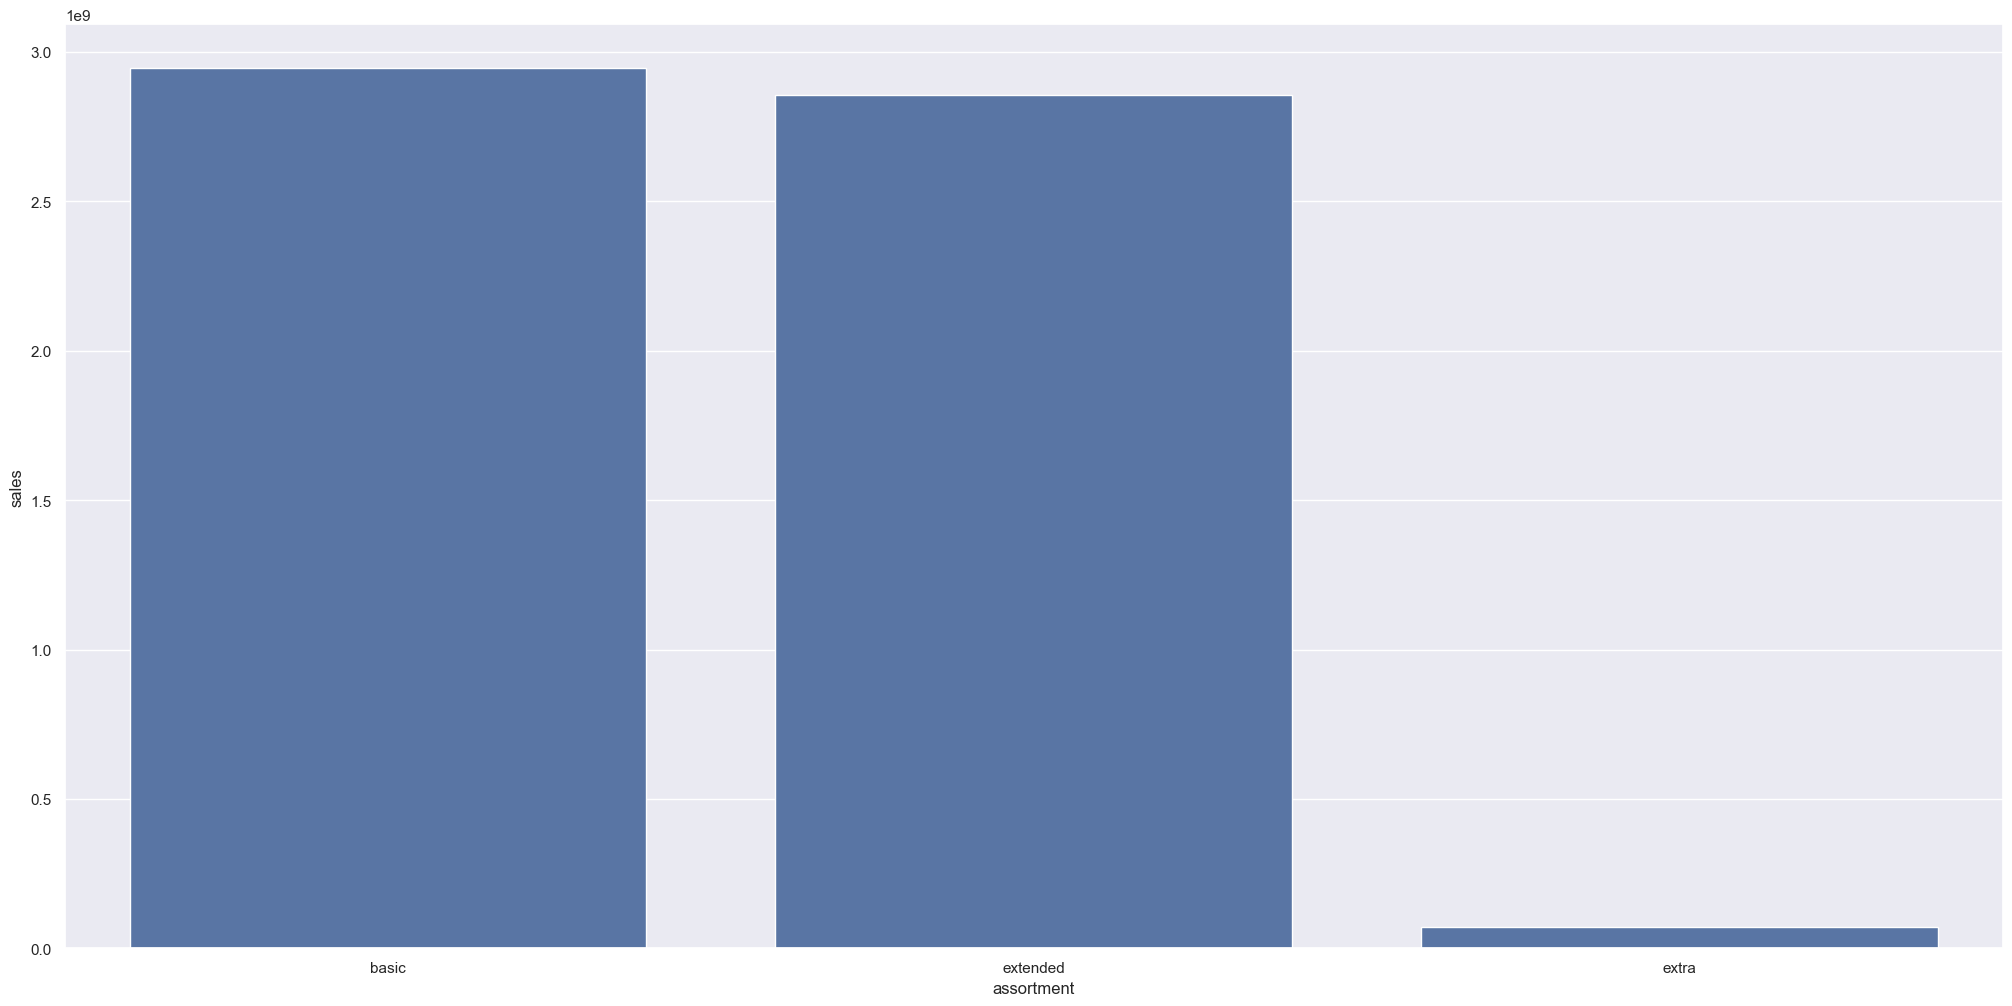

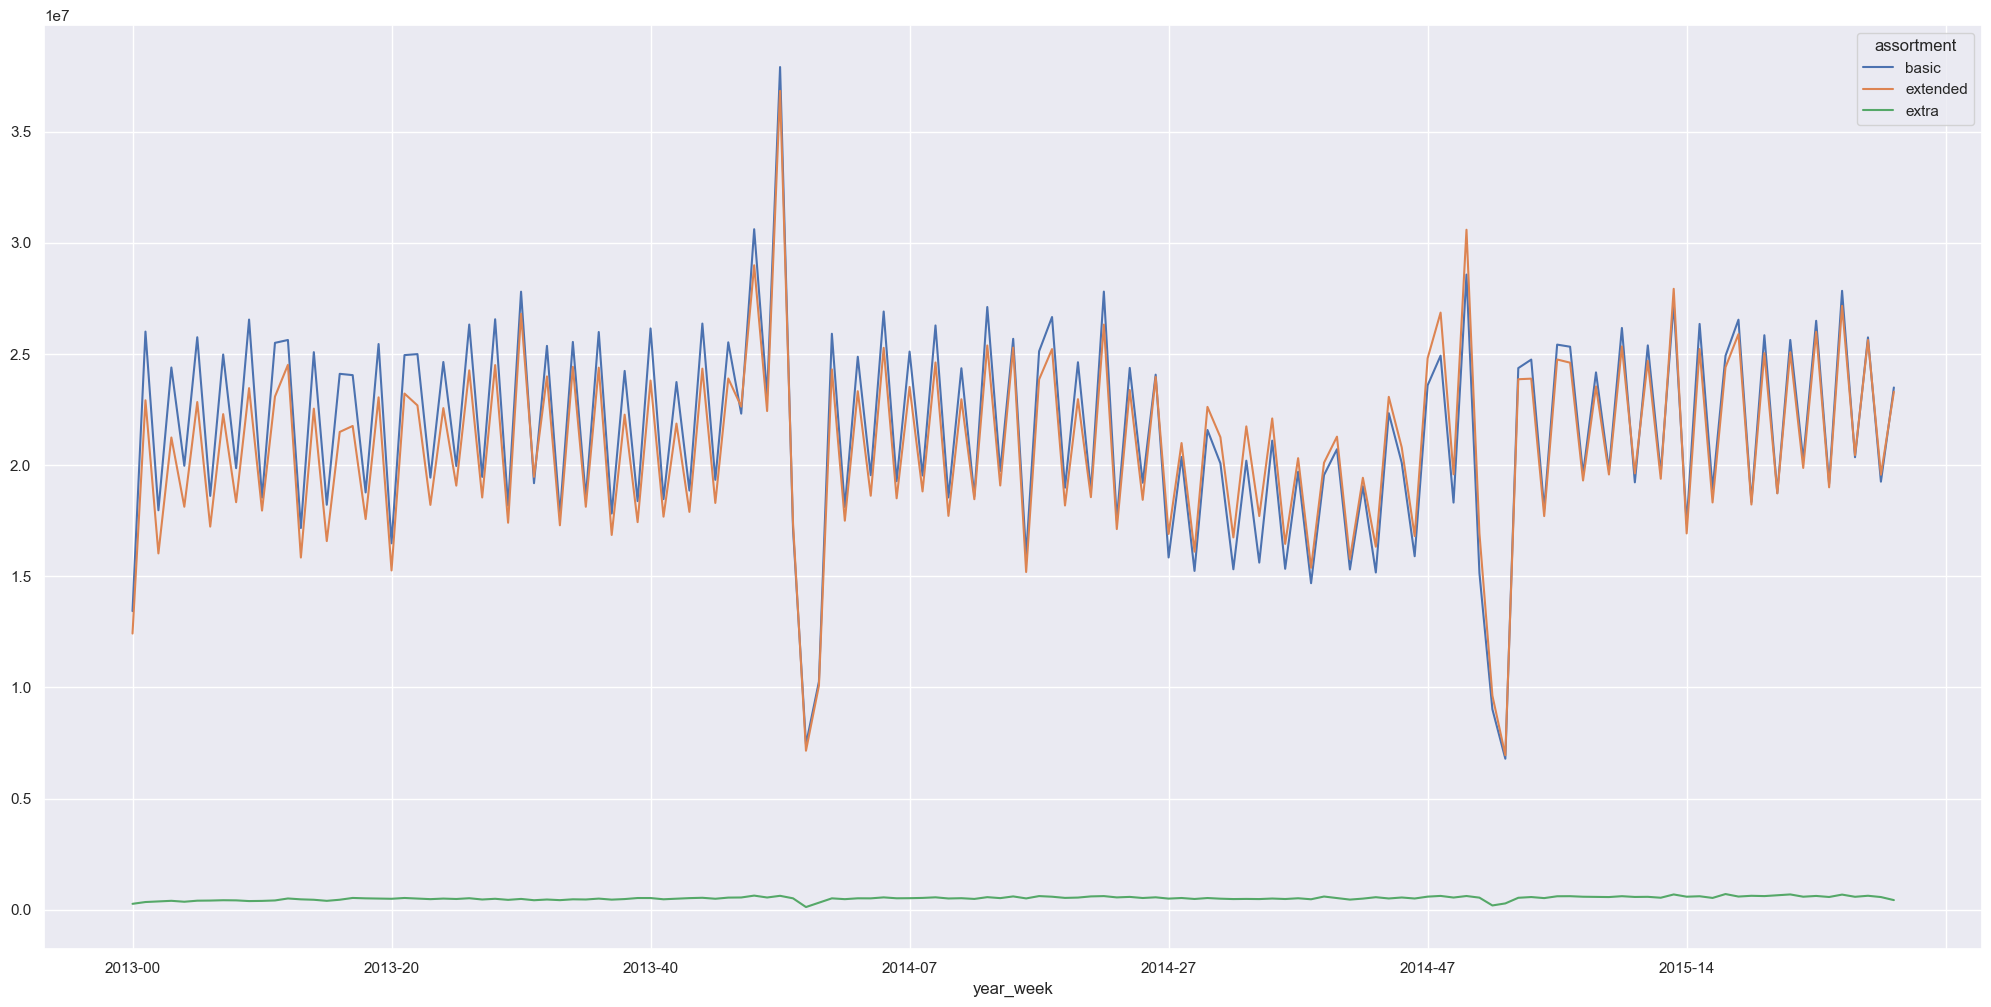

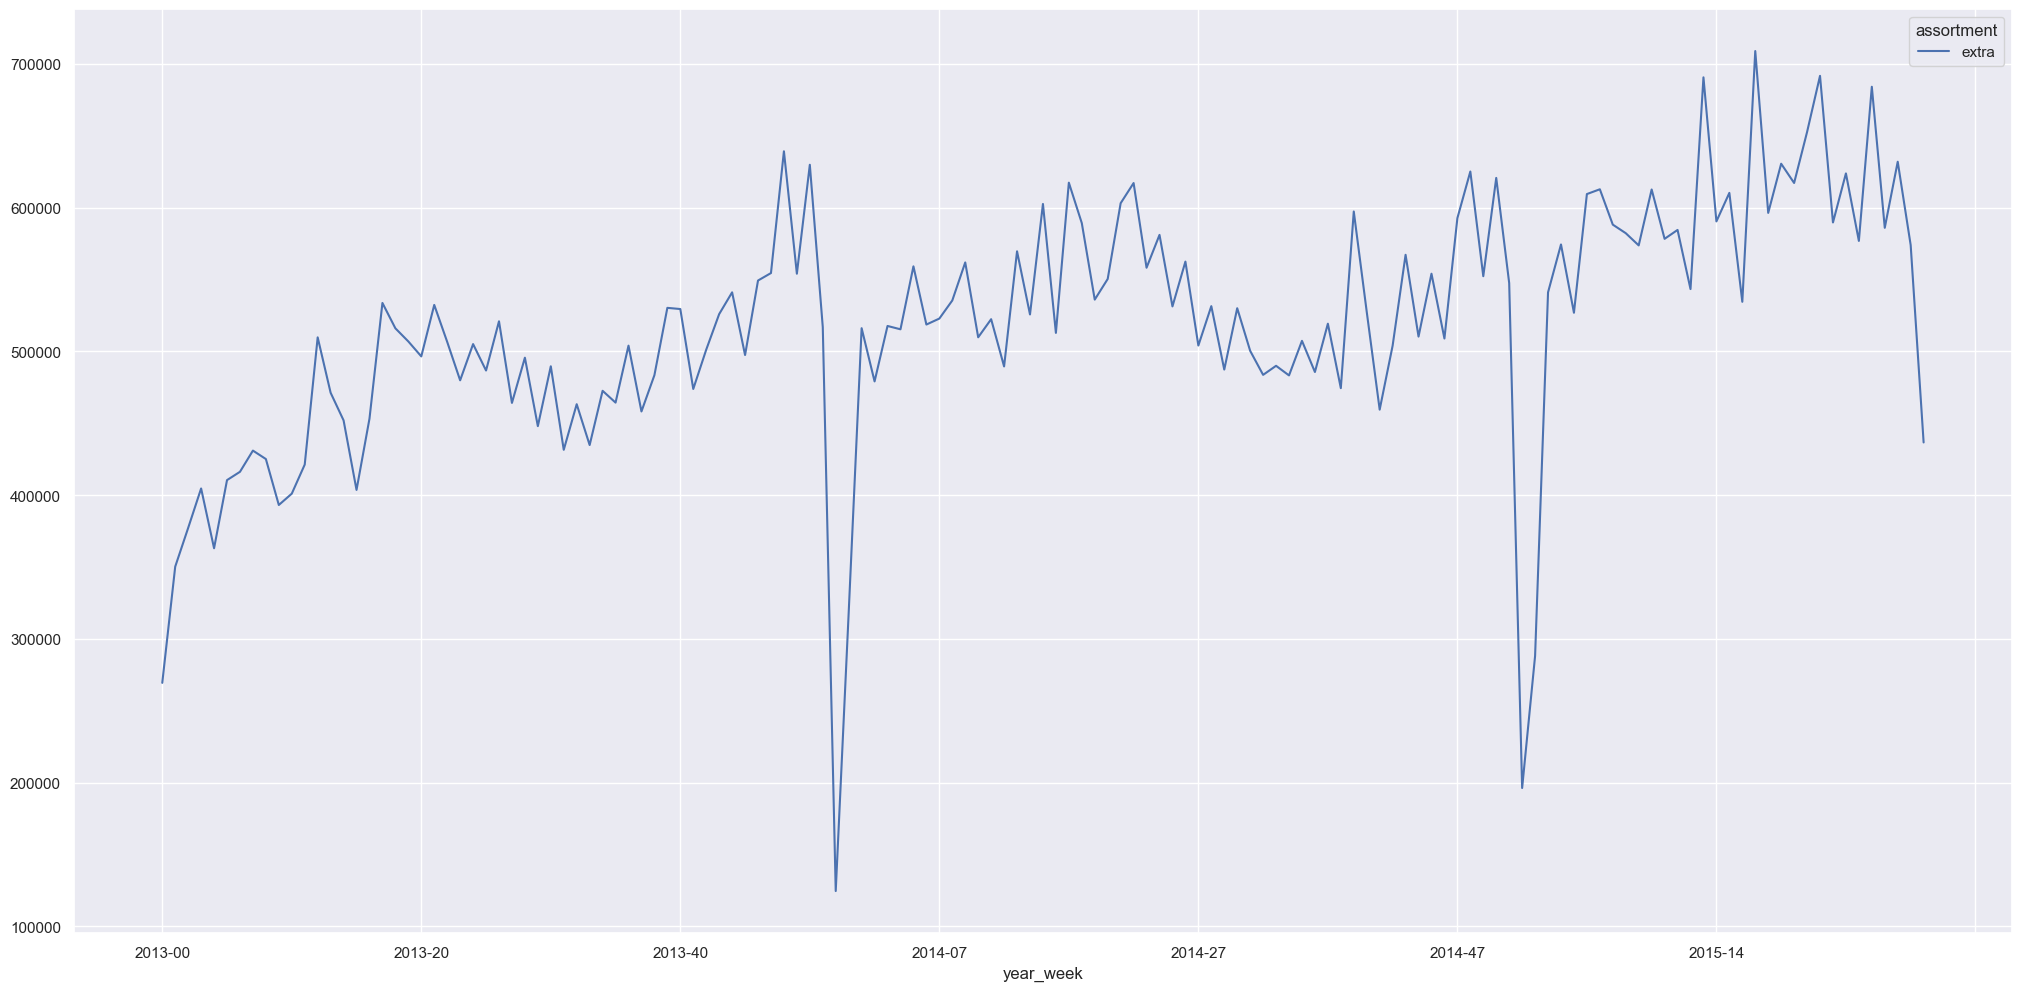

In [32]:
aux1 = df4[['assortment' , 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data= aux1)

aux2 = df4[['year_week','assortment' , 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index= 'year_week' , columns= 'assortment' , values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index= 'year_week' , columns= 'assortment' , values='sales').plot()


#lojas com maior sortimento vendem menos com base nos dados

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Competidores mais próximos vendem mais

C:\Users\donoex\AppData\Local\Temp\ipykernel_8760\1537495470.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


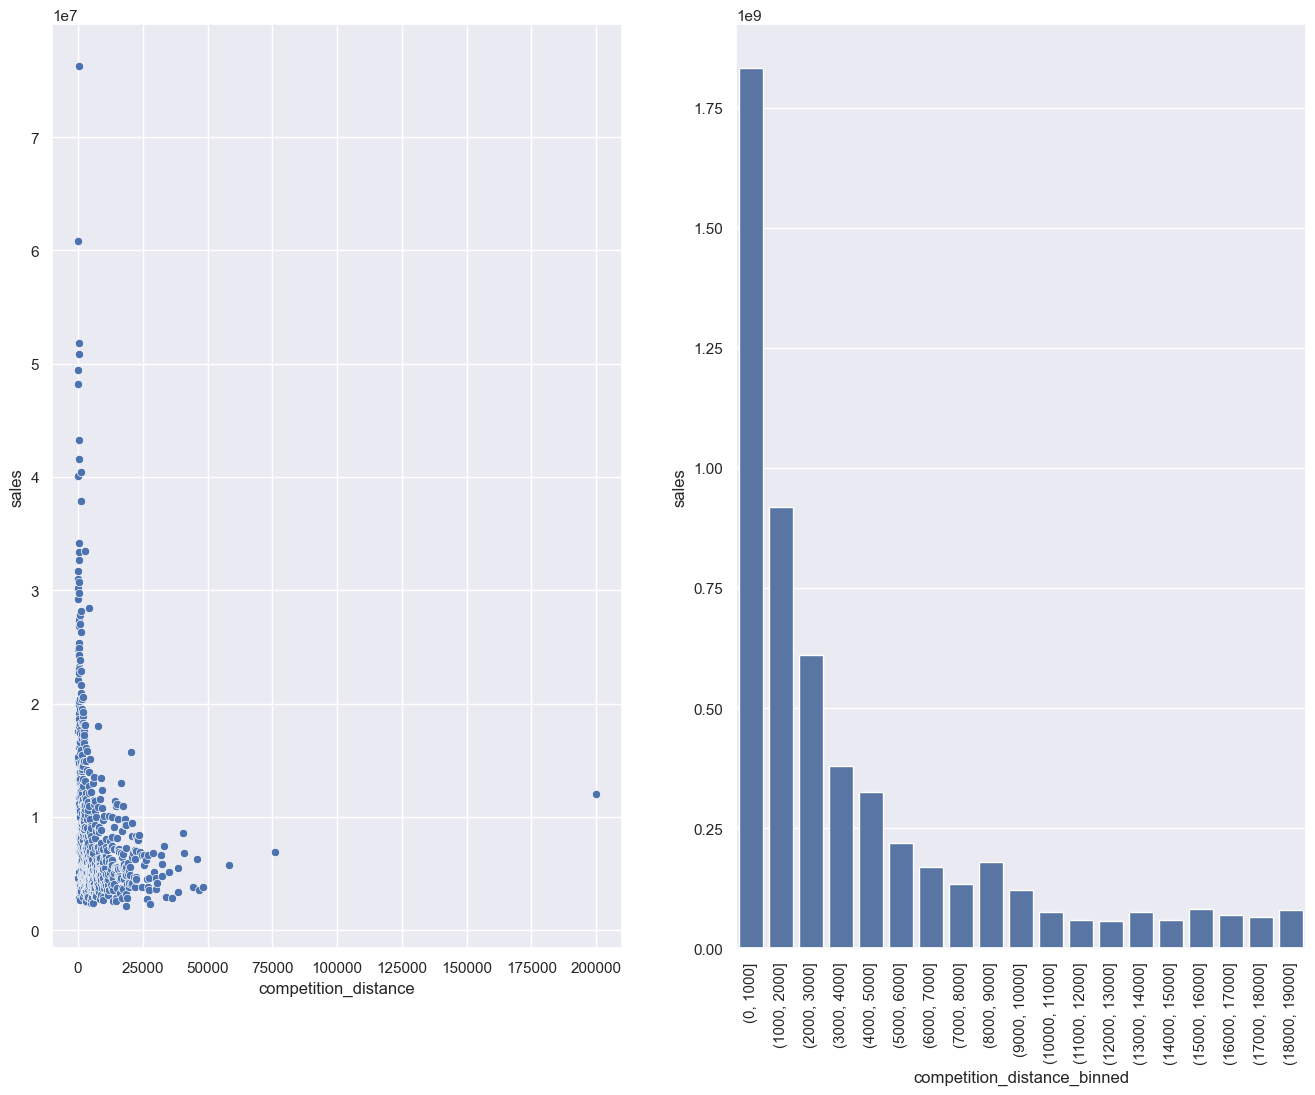

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000)) #código usado para agrupar as distancias de acordo com os valores
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data= aux2)
plt.xticks(rotation=90);

#plt.subplot(1,3,3)
#sns.heatmap(aux1.corr(method='pearson'), annot=True);



In [34]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H3. Lojas com competidores à mais tempo deveriam vender mais.
***Falsa*** lojas com competidores a mais tempo vendem menos

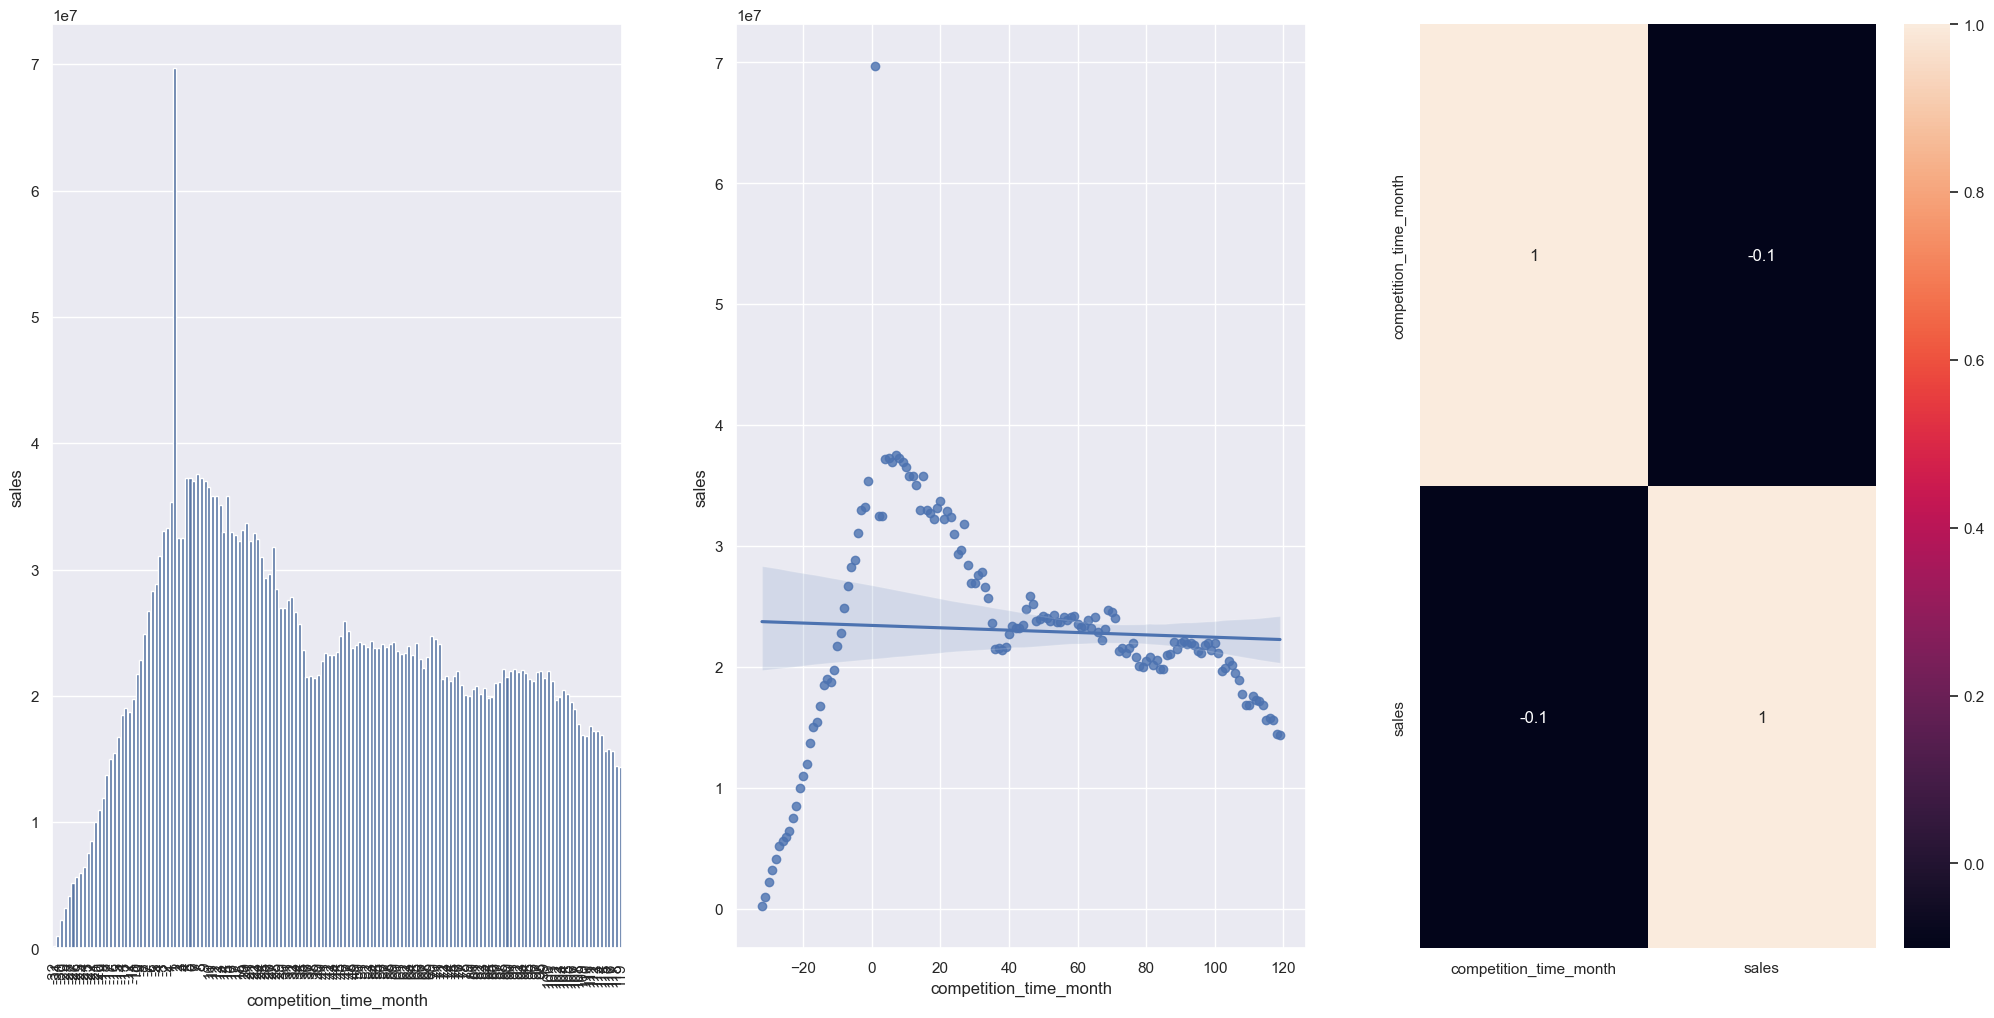

In [35]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation = 90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2) #plota tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempod everiam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos depois de um certo periodo de promoção

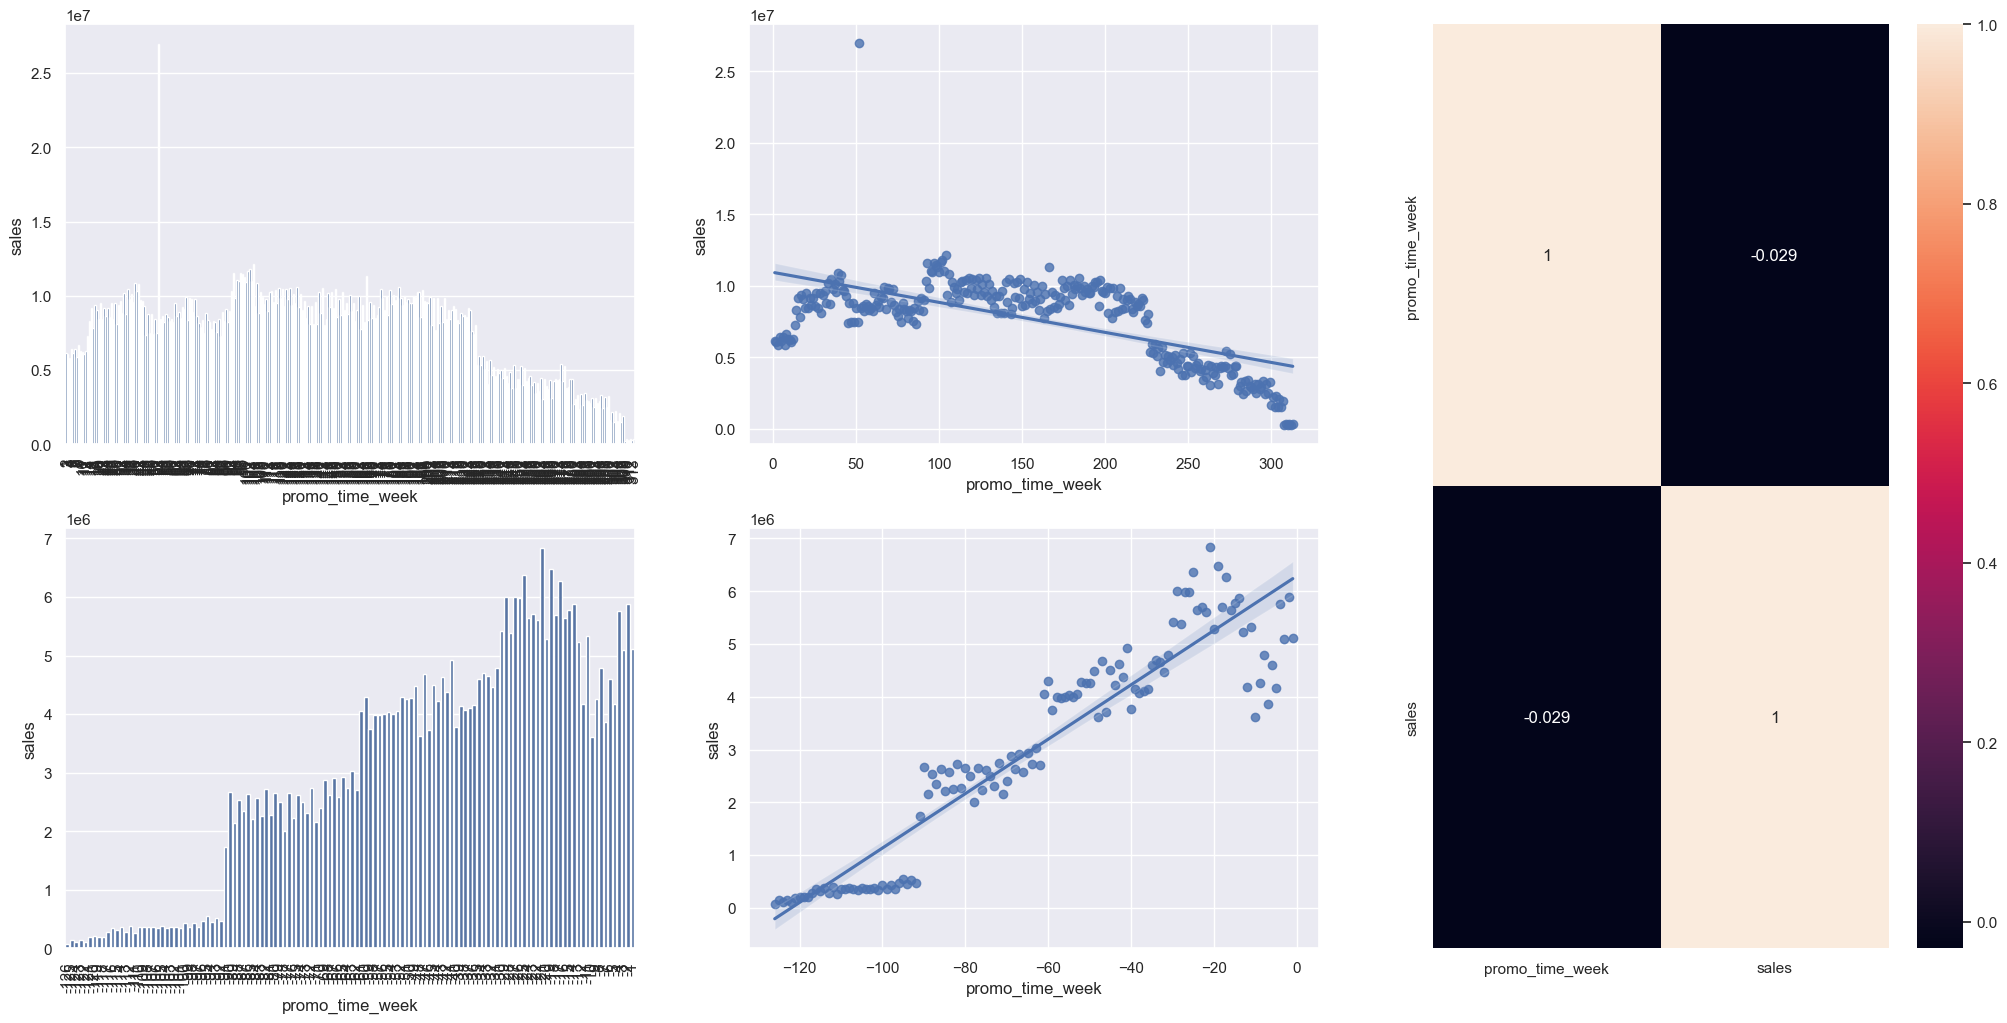

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec (2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

In [37]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H5. Lojas com mais dias de promoção deveriam vender mais.


### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [38]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


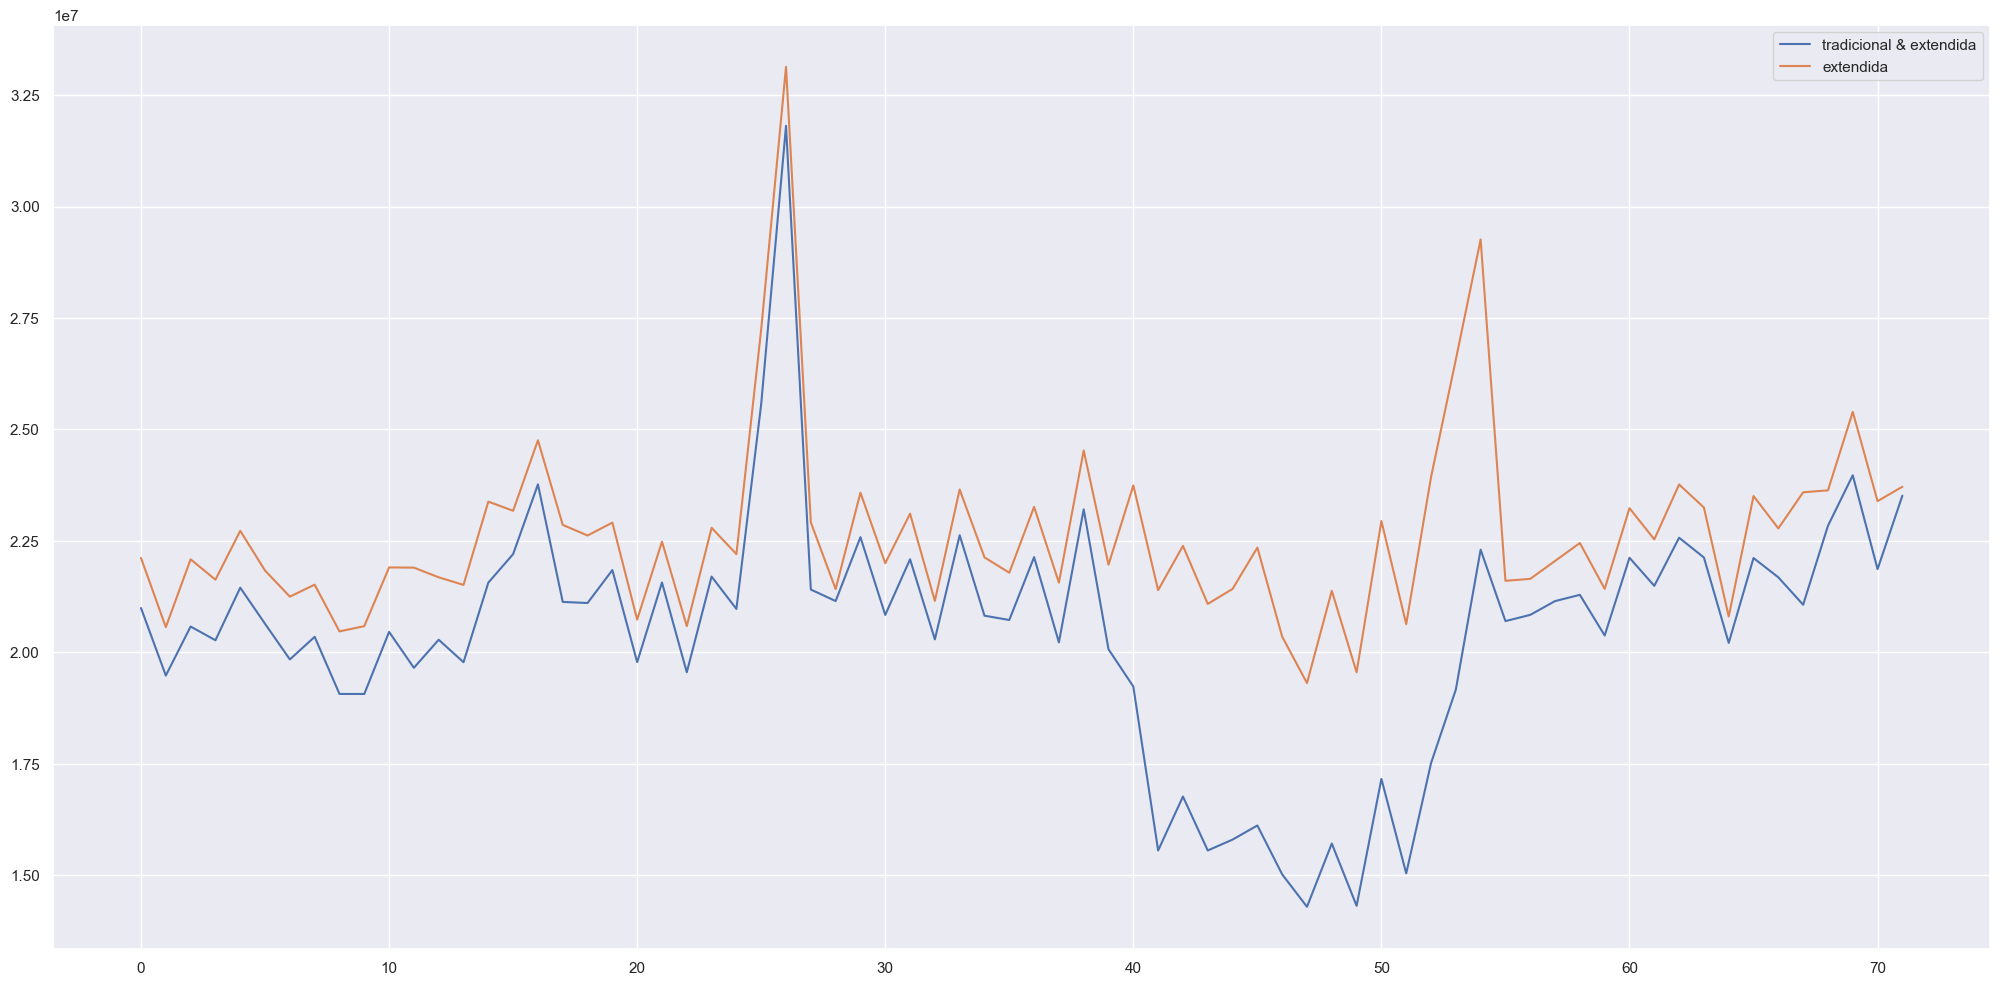

In [39]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['tradicional & extendida','extendida']);

### H7. Lojas abertas durante o feriado de natal deveriam vender mais
**FALSA** Lojas abertas durante natal vendem menos

<Axes: xlabel='year', ylabel='sales'>

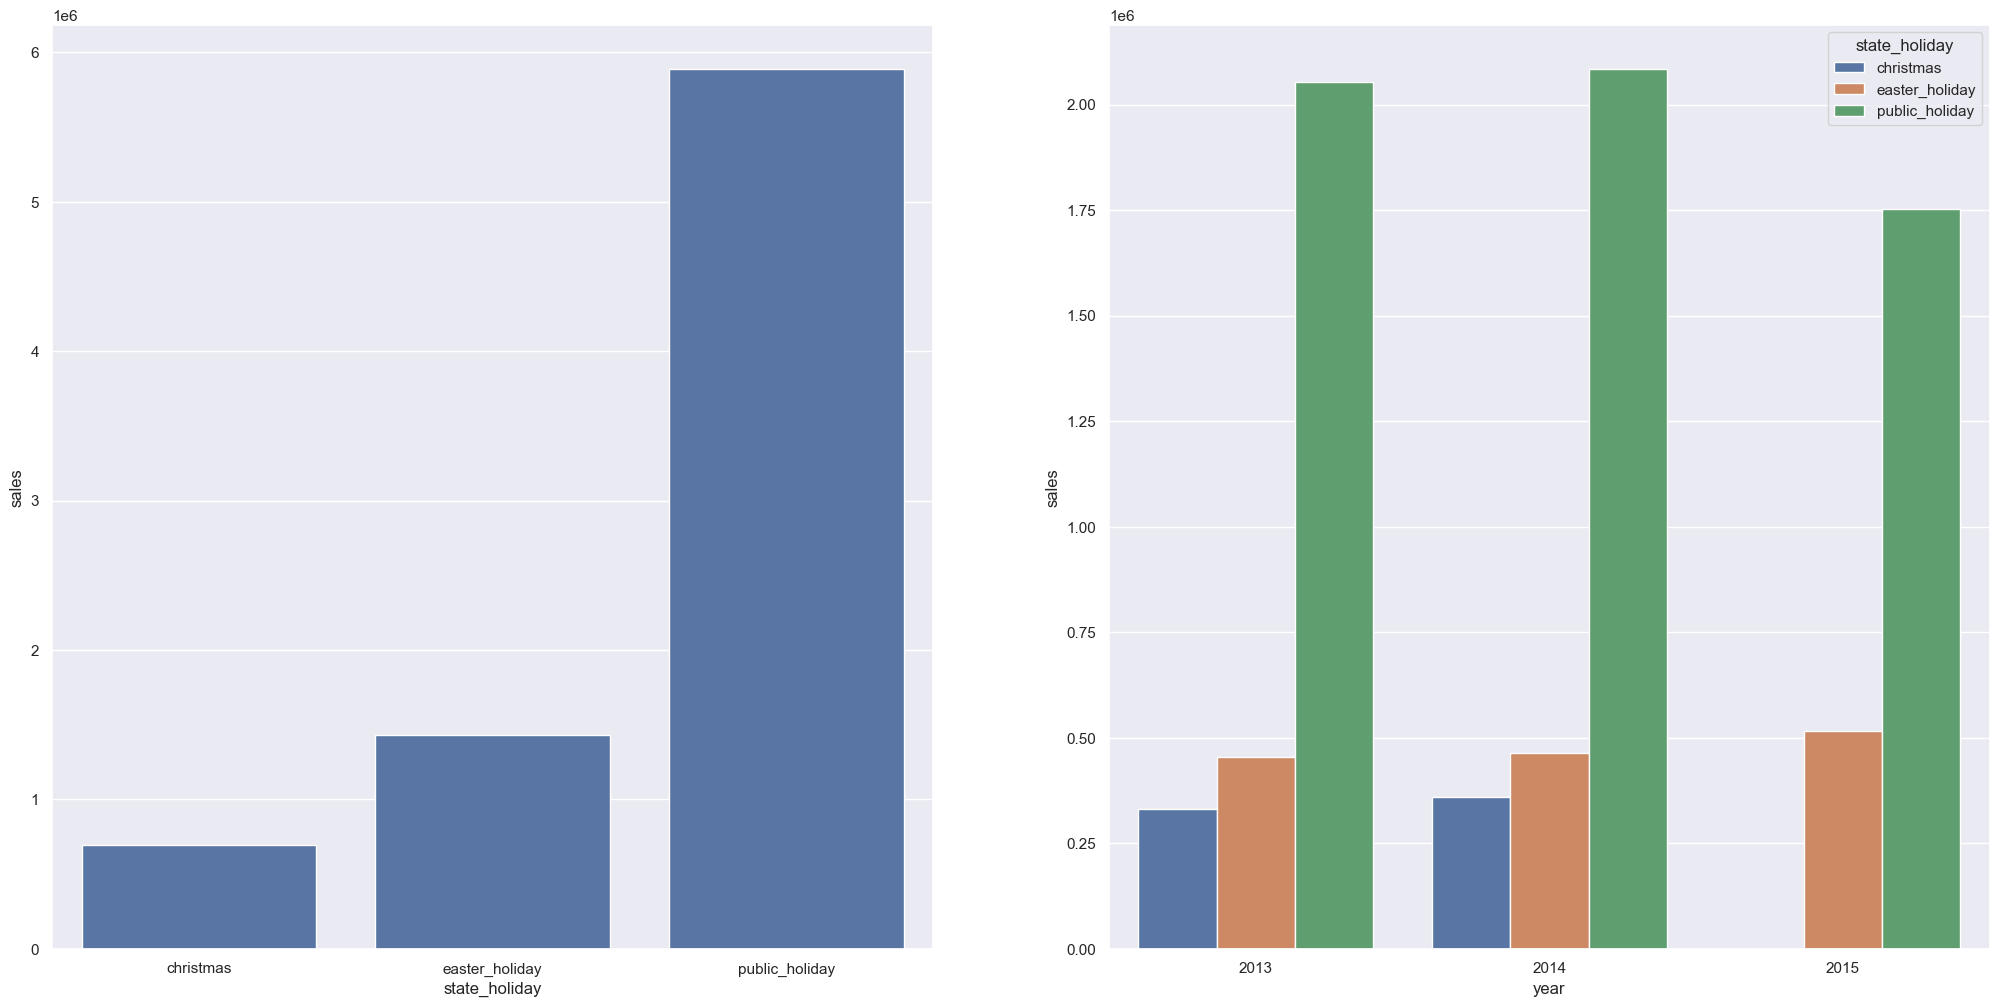

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday' ).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)


plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2)

### H8. lojas deveriam vender mais ao longo dos anos
***Falsa*** Lojas vendem menos ao longo dos anos

<Axes: >

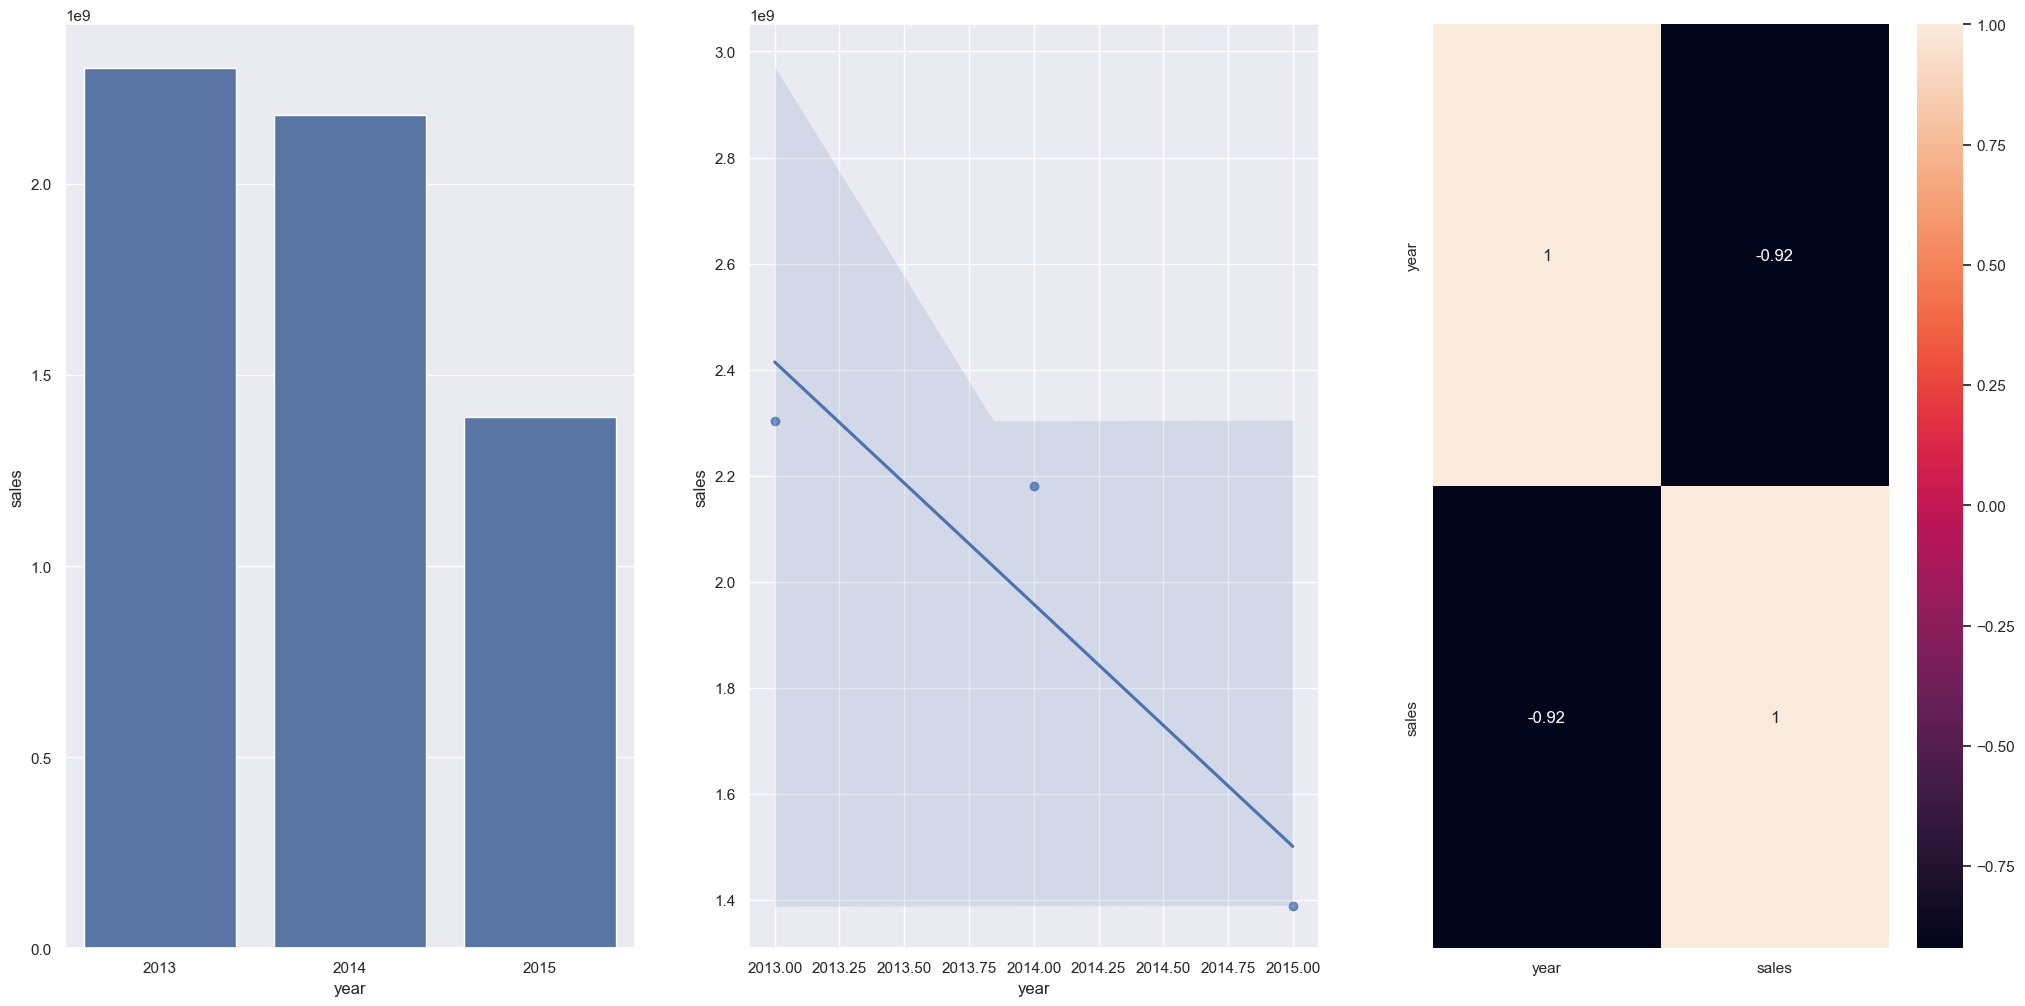

In [41]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9. lojas deveriam vender mais no segundo semestre do ano
***Falsa*** Lojas vendem menos no segundo semestre do ano

<Axes: >

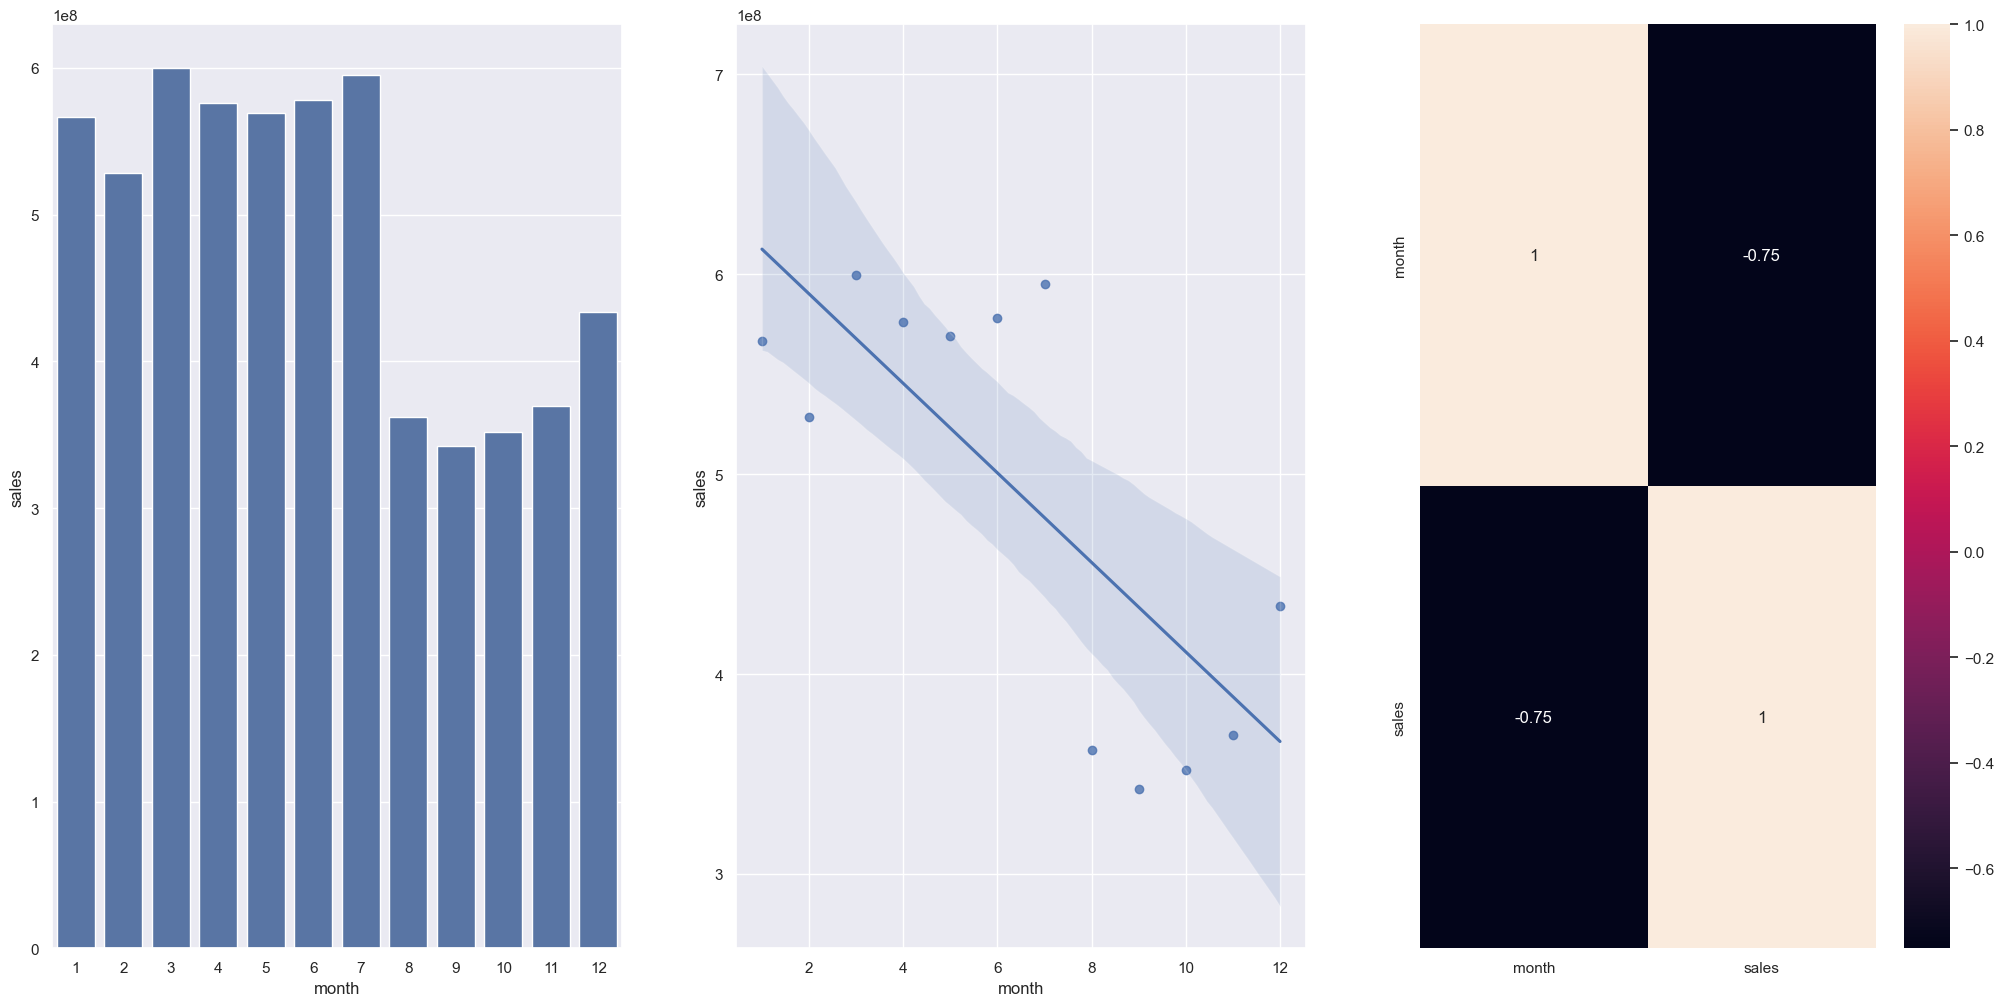

In [42]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H10. lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês

<Axes: xlabel='before_after', ylabel='sales'>

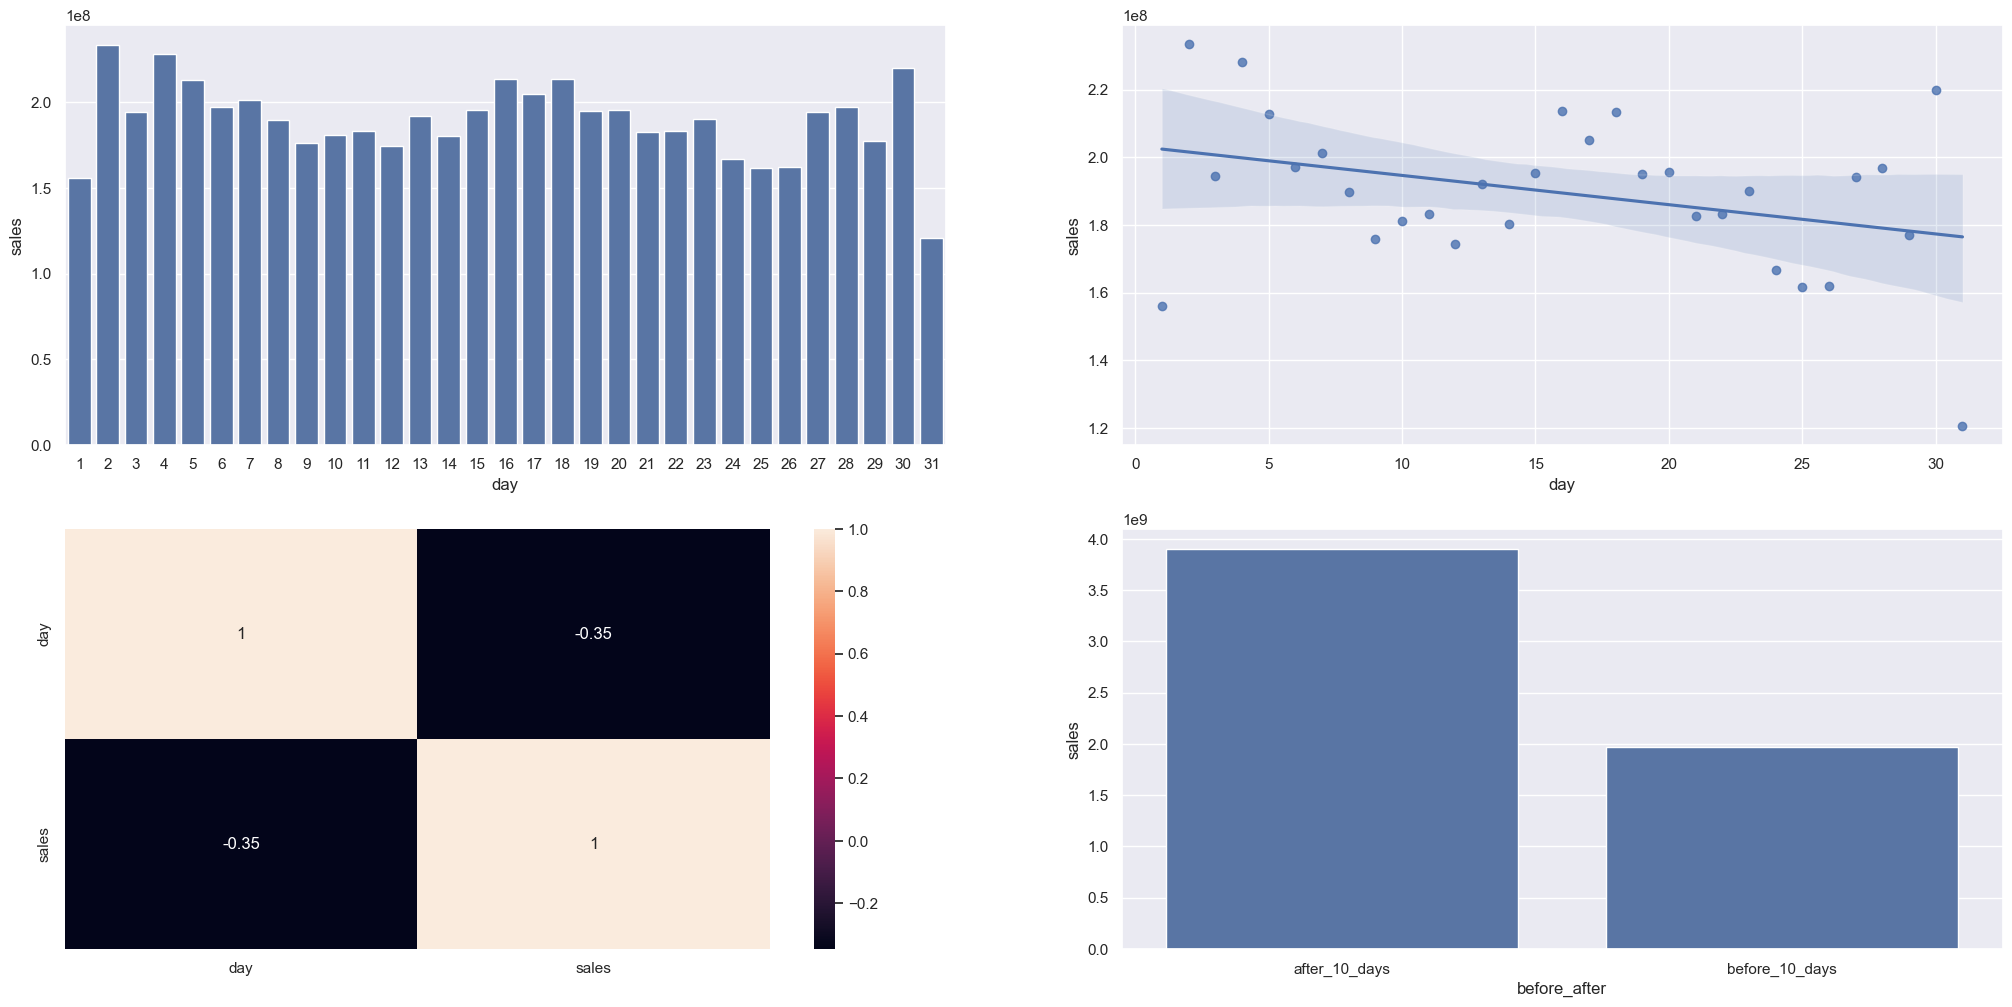

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

### H11. lojas deveriam vender menos aos finais de semana
***Verdadeira*** Lojas vendem menos aos finais de semana


<Axes: >

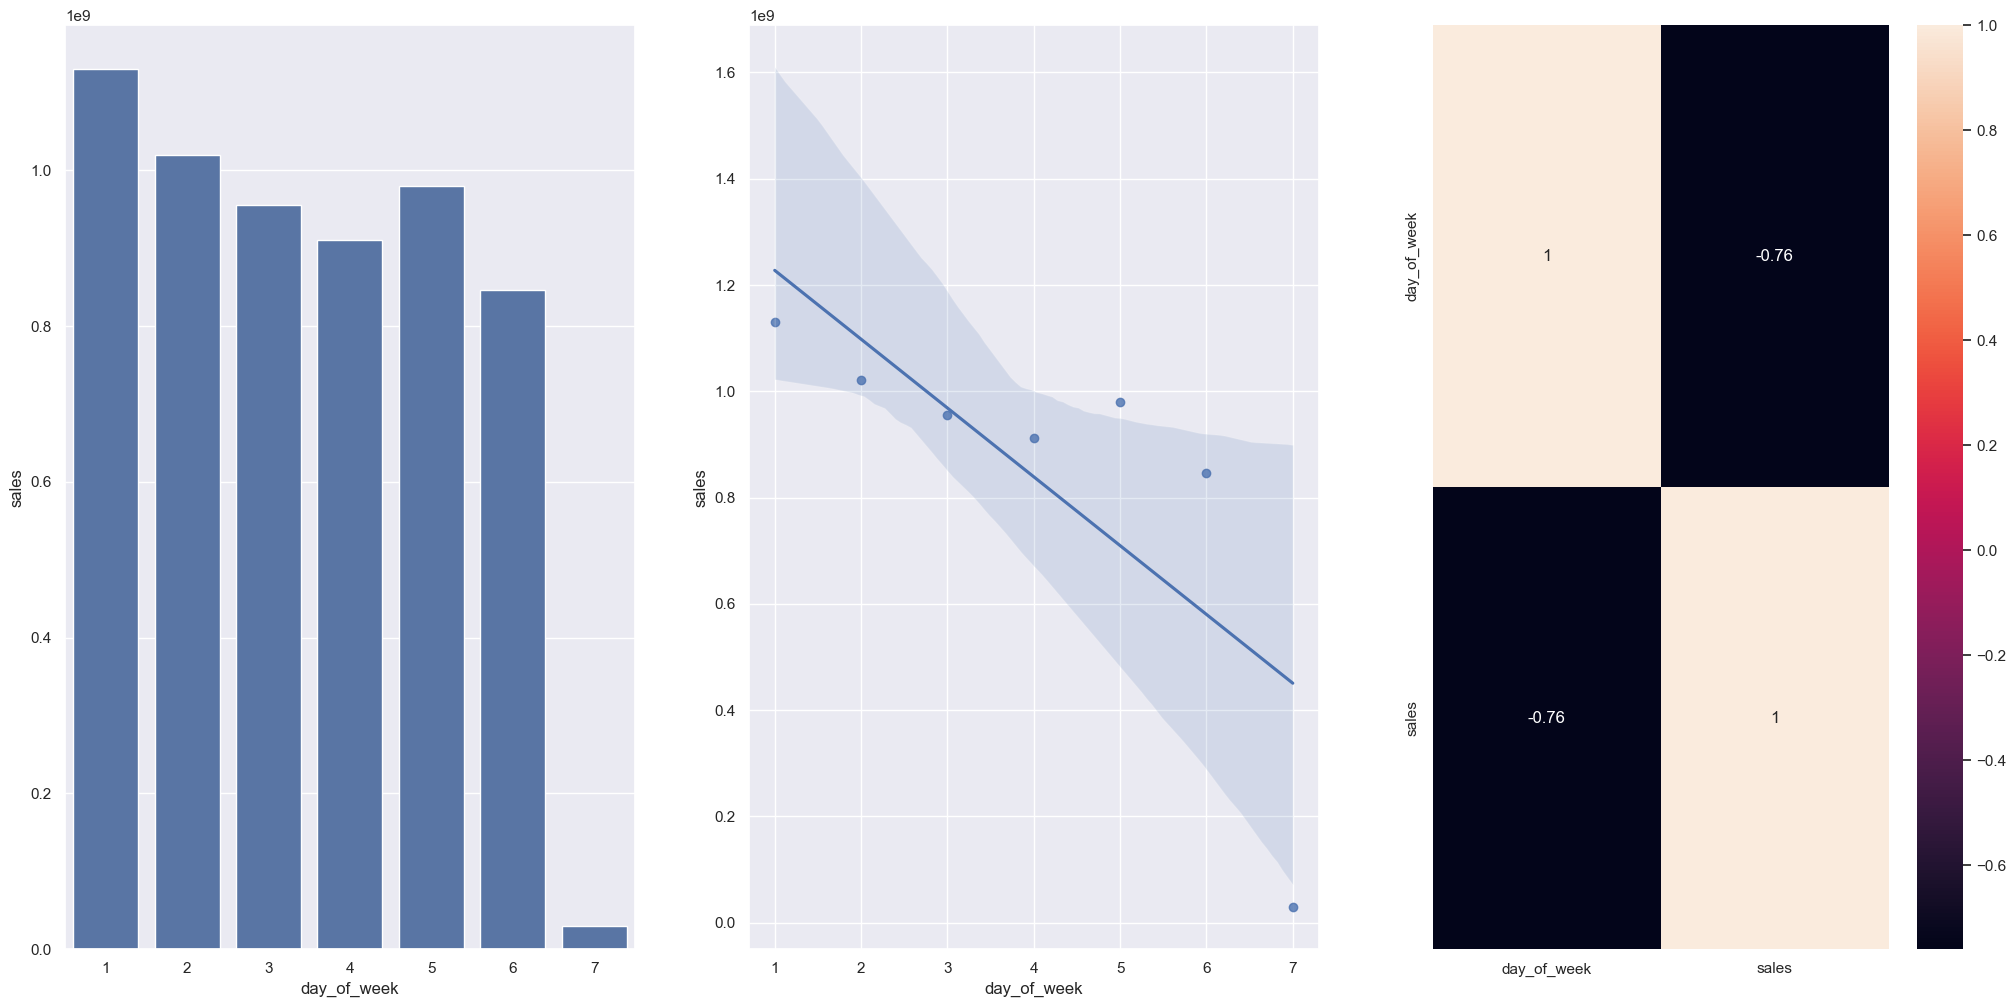

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H12. lojas deveriam vender menos durante os feriados escolares.
***Verdadeira*** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

<Axes: xlabel='month', ylabel='sales'>

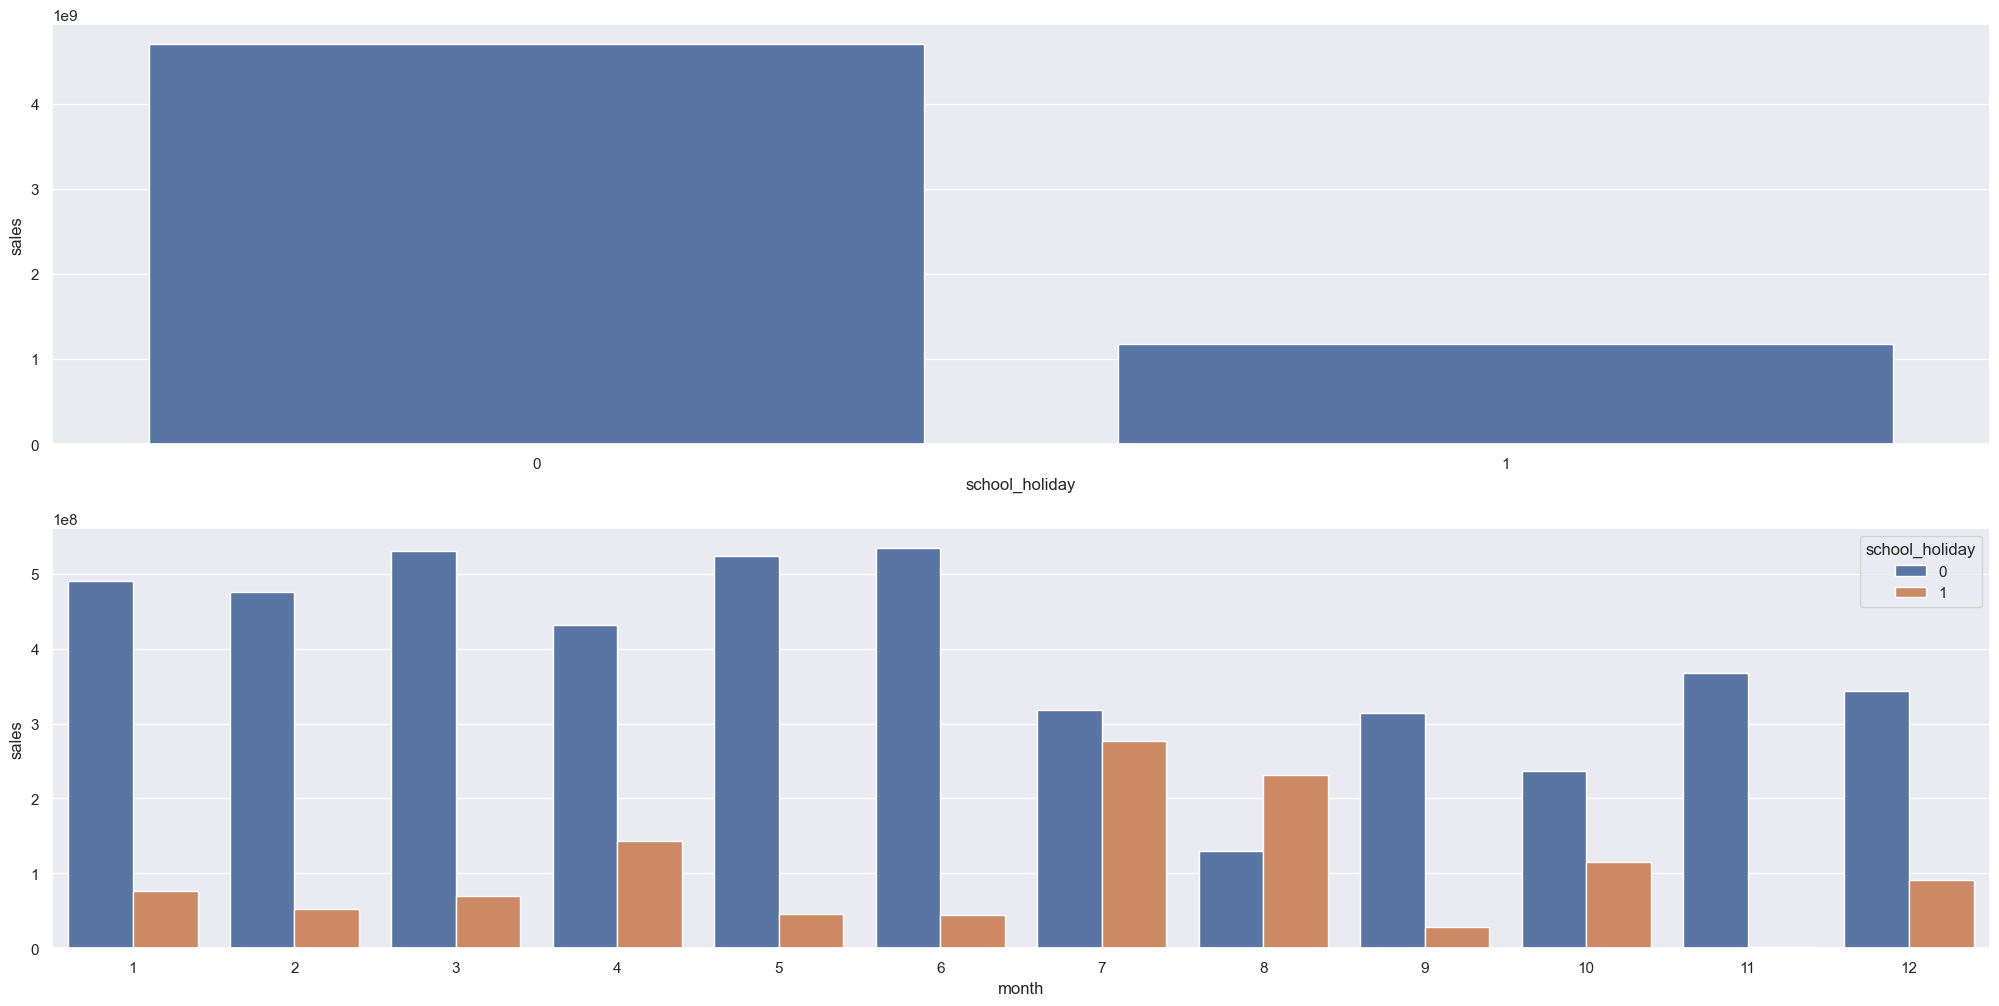

In [45]:

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)


aux2 = df4[['school_holiday','sales', 'month']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)



### 4.2.1 - Resumo das Hipoteses

In [46]:
from tabulate import tabulate

tab= [['Hipotese', 'Conclusao', 'Relevancia'],
      ['H1' , 'Falsa', 'Baixa'],
      ['H2' , 'Falsa', 'Media'],
      ['H3' , 'Falsa', 'Media'],
      ['H4' , 'Falsa', 'Baixa'],
      ['H5' , '-', '-'],
      ['H6' , 'Falsa', 'Baixa'],
      ['H7' , 'Falsa', 'Media'],
      ['H8' , 'Falsa', 'Alta'],
      ['H9' , 'Falsa', 'Alta'],
      ['H10' , 'Verdadeira', 'Alta'],
      ['H11' , 'Verdadeira', 'Alta'],
      ['H12' , 'Verdadeira', 'Baixa']
     ]
      
print (tabulate(tab, headers='firstrow'))

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 - Analise Multivariada

### 4.3.1 - Numerical Attributes

<Axes: >

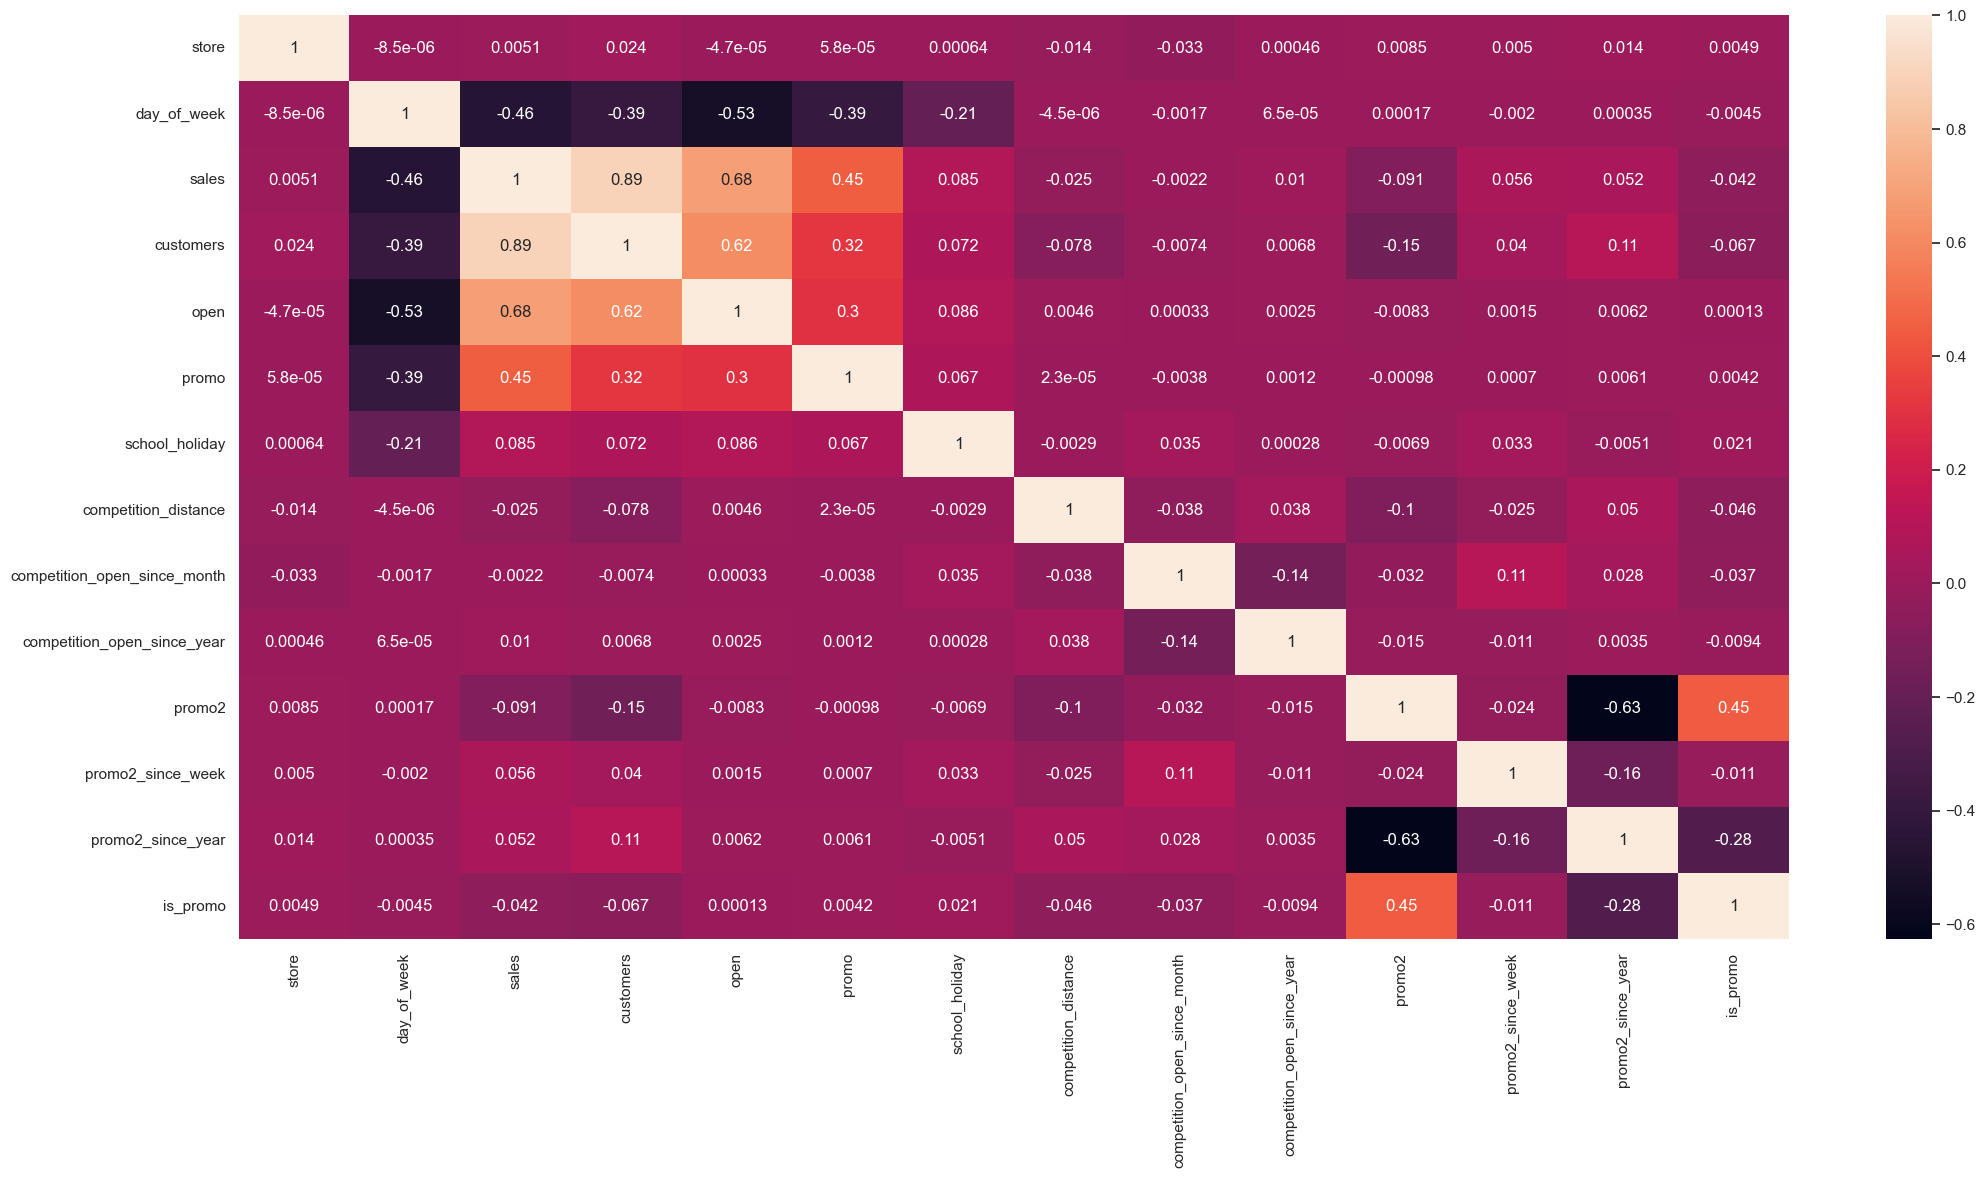

In [47]:
correlation = num_attributes.corr(method='pearson') #pearson é um modelo estatistico que calcula a correlação de uma categoria numerica com outra
sns.heatmap(correlation, annot=True)

### 4.3.2 - Categorical Attributes

In [48]:
#com atributos categoricos é necessário usar o cramer V

a = df4.select_dtypes(include = 'object') #criar um df com apenas os valores com 'object'

cm = pd.crosstab(a['state_holiday'], a['store_type']).values #criar matriz dos valores que deseja descobrir a correlação, values cria a matriz apenas com os valores

chi2 = ss.chi2_contingency(cm)[0]

n = cm.sum()
r, k = cm.shape

v = np.sqrt( ( chi2/n ) / ( min ( k-1, r-1) ) ) 
# V é o resultado da correlação entre as categorias usadas no calculo, quanto mais perto do 0 menor a correlação e mais perto do 1 maior a correlaçãop


In [49]:
# resultado do chi2 antes de determinar o uso apenas do resultado statistic

# Chi2ContingencyResult(statistic=12792.159524019908, pvalue=0.0, dof=9, expected_freq=array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
#       [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
#       [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
#       [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

In [50]:
#criando função para usar em todos os valores desejados de forma mais rápida
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values #criar matriz dos valores que deseja descobrir a correlação, values cria a matriz apenas com os valores
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) # valores com corr são as correções dos valores, porque o cramer v tem um alto vies em relação ao estimador, no caso ele sempre fala um numero muito maior
    kcorr = k - (k-1)**2/(n-1)                  # do que realmente é na força da associação, visto isso é necessário fazer essa correção
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1, rcorr-1) ) ) # V é o resultado da correlação entre as categorias usadas no calculo, 
                                                                   # quanto mais perto do 0 menor a correlação e mais perto do 1 maior a correlação
    

<Axes: >

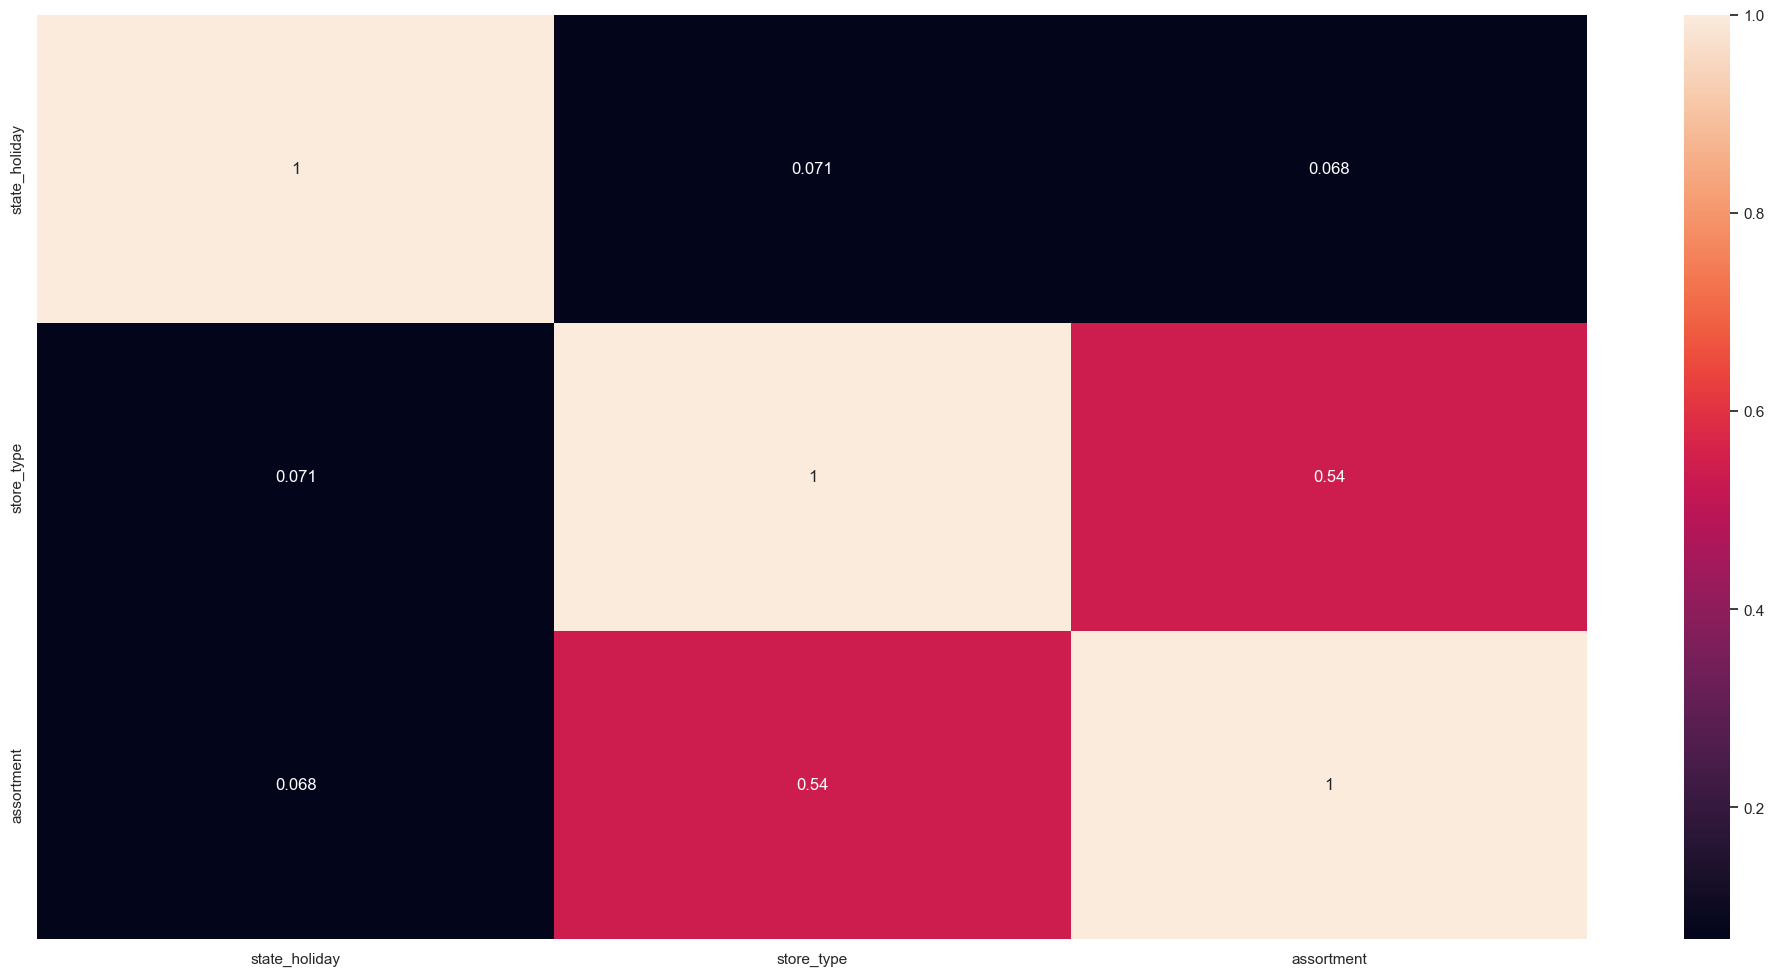

In [51]:
#criação das matrizes para calculo do cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


#criar um df com os resultados
d = pd.DataFrame ( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] } )

d = d.set_index(d.columns) #coloca o nome das linhas no lugar do index 

sns.heatmap( d, annot=True)

# 5.0 PASSO 05 (modelagem) -  DATA PREPARATION (preparar os dados para o aprendizado)

In [52]:
df5 = df4.copy()


## 5.1 - Normalização

In [53]:
# re-escala o centro para 0 com desvio padrão igual a 1
# funciona muito bem em variaveis com distribuição normal  (grafico aumenta gradativo e diminui gradativo)


## 5.2 - Rescaling

In [54]:
#deixar todas a variaveis numericas dentro da mesma escala

# min-max scaler -> (valor da variavel - média) / (max variavel - min variavel)
# super sensivel a outliers

#robust scaler -> (valor da variavel - Q1) / (Q3 - Q1)
#robust scaler foi criado para tirar os outliers, gráfico de boxplot mostra o quartil 1 (Q1) e o quartl 3 (Q3)

#recomenda-se usar min-max nas variaveis que não tiver outlier muito forte e robust nas que houverem outlier forte

a = df5.select_dtypes( include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [55]:
# colunas que será feito rescaling

# day_of_week
# competition distance
# year
# month
# day
# week of year
# competition time month
# promo time week

# separar as variaveis de natureza ciclica 

# variaveis de natureza ciclica
# month
# day
# week of year
# day of week

# variaveis não ciclicas
# competition distance
# year
# competition time month
# promo time week

In [122]:
rs = RobustScaler()
mms = MinMaxScaler()

# variaveis não ciclicas
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)  # fit_transform encontra os parametros da formula e ja aplica nos dados (localiza os quartis e ja aplica a formula)
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open('parameter/competition_distance_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3 - Transformação


In [57]:
# Tipos de Transformação

# Logarithm Transformation
# Box-Cox Transaformation
# Cube-Root Transformation
# Square-Root Transformation
# Sine and Cosine Transformation

### 5.3.1 - Enconding


In [58]:
#enconding - transformar as variaveis categoricas em variaveis numericas sem perder seus valores

# tipos de enconding

# One hot Enconding 
   # pd.get_dummies
    
# Label enconding
    # LabelEncoder().fit_transform( coluna )

# Ordinal enconding
    # criar dict com respectivos valores ordinais (ex: {'basic': 1, 'extra': 2,'extended': 3} )
    # depois usar coluna_desejada '.map( dict criado )' para mapear os valores da coluna original com os valores atribuidos

# Target enconding


# frequency enconding


# embedding enconding

In [59]:
# state_holiday - One Hot Enconding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])


In [123]:
# store_type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb'))

In [61]:
# assortment - Ordinal Enconding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True


### 5.3.2 - Response Variable Transformation


In [63]:
# Logarithm Transformation
df5['sales'] = np.log1p(df5['sales'])


### 5.3.3 - Nature Transformation (variaveis ciclicas)

In [64]:
# definir as variaves que terão natureza trocada, variaveis ciclicas

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) ) 
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) ) 

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) ) 


# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2. * np.pi/12) ) ) 
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2. * np.pi/12) ) ) 


# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2. * np.pi/30) ) ) 
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2. * np.pi/30) ) ) 


# week of year
#df5['year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/12) ) ) 
#df5['year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/12) ) ) 
df5.head()



,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148


# 6.0 PASSO 06 (modelagem) - FEATURE SELECTION (seleciona as variaveis mais relevantes para o modelo)

In [65]:
# Métodos de Seleção de Variáveis (classificar as variaveis se são relevantes ou não)

# Seleção Univariada (Filter Methods)
    # Coeficiente de Correlação

# Seleção por Importancia (Embedded Method)
    # Random Forest / Lasso & Ridge Regression

# Seleção por SubSet (Wrapper Methods)



In [66]:
df6 = df5.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True,0.433884,-0.900969,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148


## 6.1 - Split Dataframe Into Training and Teste Dataset (separar dataset para o treino e para o test)

In [67]:
# excluir colunas originais por conta que foram derivadas (ex: day criou a derivação de day_sin e day_cos)

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
# promo_since derivou promo_time_week
# competition_since derivou competition_time_month
# year_week derivou
# week_of_year derivou o week_of_year_sin e week_of_year_cos
# day derivou o day_sin e day_cos
# month derivou o month_sin e month_cos
# day_of_week derivou o day_of_week_sin e day_of_week_cos

df6 = df6.drop(cols_drop, axis=1)

In [68]:
#foi usado as ultimas 6 semanas de vendas como df para teste e o restante dos dados será usado para treino

# df6[['store','date']].groupby('store').max().reset_index() #achar primeira e ultima data
#primeira data -> 2013-01-02
#ultima data -> 2015-07-31

df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7) #localizar a data que começa as ultimas 6 semanas
#do dia 2015-06-19 ao dia 2015-07-31 -> é referente as ultimas 6 semanas -> DADOS DE TESTE
#do dia 2013-01-02 ao dia 2015-06-18 -> é referente aos dados sem as ultimas 6 semanas -> DADOS DE TREINO

Timestamp('2015-06-19 00:00:00')

In [69]:
#training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']


#teste dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']


print(f" Max Date Training: {x_train['date'].max()}")
print(f" Min Date Training: {x_train['date'].min()}")
print(f" Max Date Test: {x_test['date'].max()}")
print(f" Min Date Test: {x_test['date'].min()}")

 Max Date Training: 2015-06-18 00:00:00
 Min Date Training: 2013-01-01 00:00:00
 Max Date Test: 2015-07-31 00:00:00
 Min Date Test: 2015-06-19 00:00:00


## 6.2 - Boruta as Feature Selector

In [70]:
#training and testing dataset for Boruta
# os dados usados deveram estar em numpy, no caso apenas valores e não deve estar como DF
x_train_n = x_train.drop(['date', 'sales'], axis=1).values # é necessario eliminar coluna date e sales, porque são dados de treino / values é usado para pegar só os valores e não o df inteiro
y_train_n = y_train.values.ravel() # ravel-> usado para colocar dentro de um vetor 


#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1) #n_jobs = -1 -> usado para usar todos os cores da máquina e fazer tudo em paralelo, para ser mais rapido



In [71]:
#define boruta

# boruta = BorutaPy (rf , n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

# rf = random forest -> metodo usado
# N_estimators -> quantidade de arvores
# verbose -> usado para ir plotando ao longo da execução
# random_state -> usado para sempre inicializar a partir daquele mesmo ponto (pode ser qualquer valor inteiro)

In [72]:
# Iteration: quantidade de iterações que o algoritmo teve até definir as features
# Confirmed: quantidade de features que o algoritmo considerada relevante
# Tentative: quantidade de festures que o algoritmo tem duvida se é relevante mesmo ou não
# Rejected: quantidade de features que o algoritmo não considera relevante

### 6.2.1 - Best Features from Boruta

In [73]:
#  cols_selected = boruta.support_.tolist()
#  #support é o valor do rank que rankeou de acordo com a relevancia das features
#  #é criado a lista com to_list() com o numero do rank e o numero da coluna
#  
#  #best features
#  x_train_fs = x_train.drop(['date', 'sales'], axis=1) #criado um dataset sem as colunas date e sales, mas que dessa vez retorne o nome das colunas tambem
#  cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list() #localiza o nome das colunas de acordo com seus respectivos numero , por isso usado o iloc
#  
#  
#  #features not selected botura
#  cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta)) #setdiff1d ele retorna os valores que tem em x_train_fs e não tem em cols_selected_boruta
#  cols_selected_boruta

## 6.3 - Manual Features Selection

In [74]:
#salvar as colunas dadas como relevante pelo boruta para não perder tempo de novo na próxima execução
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']
                    

#adicionar as colunas date e sales de volta ao dataset
#columns to add
feat_to_add = ['date', 'sales']


#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [75]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [76]:
x_train2 = x_train[cols_selected_boruta]
x_test2 = x_test[cols_selected_boruta]

In [77]:
#Time series Data Preparation
x_training = x_train[cols_selected_boruta_full]

## 7.1 - Average Model

In [78]:
aux1 = x_test2.copy() #guarda uma copia do x_text2 para a variavel aux1
aux1['sales'] = y_test.copy() #guarda uma copia do y_test na variavel sales do aux1

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})  #calcula a média de vendas agrupadas por lojas e renomeia a coluna sales para predictions
aux1 = pd.merge(aux1, aux2, how='left', on='store')   #anexar de volta os valores nos dados originais / how -> tipo de join ... on -> coluna de referencia
yhat_baseline = aux1['predictions']


#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) 
                                  # ml_error função para calculas a performance para todos os modelos / y_test -> dados reais / yhat_baseline -> predições
                                          # função ml_error está na aba de funções criadas
                                  # ficar atento se a variavel resposta foi alterada para log
                                  # nesse caso a variavel resposta (sales)  foi alterada para log e deve retornar como exponencial (exponencial é contrario de log)
                                  # np.expm1 é o comando para transformar o valor em exponencial
baseline_result
 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression Model

In [79]:
#model
lr = LinearRegression().fit(x_train2, y_train)

#prediction
yhat_lr = lr.predict(x_test2)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result


# RMSE é valor muito mais alto que o average model, isso significa que o average model é melhor do que o modelo linear e que os dados tem um comportamento complexo, não é linear

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1866.953024,0.292619,2671.302799


### 7.2.1 - Linear Regression Model - Cross Validation

In [80]:
lr_result_cv = cross_validation ( x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.46+/-291.09,0.3+/-0.02,2946.64+/-461.11


## 7.3 - Linear Regression Regularized Model - Lasso

In [81]:
#model
lrr = Lasso(alpha =0.01).fit(x_train2, y_train)

#prediction
yhat_lrr = lrr.predict(x_test2)

#performance
lrr_result = ml_error('Linear Regression Regularized Model - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 - Linear Regression Regularized Model - Lasso - Cross Validation

In [82]:
lrr_result_cv = cross_validation ( x_training, 5, 'Linear Regression Regularized Model - Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized Model - Lasso,2116.2+/-341.42,0.29+/-0.01,3057.83+/-503.68


## 7.4 - Random Forest Regressor

In [83]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs= -1, random_state = 42).fit(x_train2, y_train)

#prediction
yhat_rf = rf.predict(x_test2)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,700.4915,0.104208,1030.871267


### 7.4.1 - Random Forest Regressor - Cross Validation

In [84]:
rf_result_cv = cross_validation ( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,847.53+/-222.78,0.12+/-0.02,1276.74+/-327.18


## 7.5 - XGBoost Regressor

In [85]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',   #
                             n_estimators = 100, 
                             eta = 0.3,  # quantas passadas ele usa para o aprendizado
                             max_depth = 6,  # maxima profundidade da arvore
                             subsample = 1, # numedo de amostras (linhas) usadas em cada árvore, definido para um valor entre 0 e 1, geralmente 1,0 para usar todas as amostras.
                             colsample_bytree = 1, # numero de recursos (colunas) usados em cada árvore, definido como um valor entre 0 e 1, geralmente 1,0 para usar todos os recursos.
                             ).fit(x_train2, y_train)
                                #valores usados são default de acordo com a documentação - https://xgboost.readthedocs.io/en/stable/parameter.html
    
#prediction
yhat_xgb = model_xgb.predict(x_test2)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,891.444188,0.133949,1277.734206


### 7.5.1 - XGBoost Regressor - Cross Validation

In [86]:
xgb_result_cv = cross_validation ( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1057.23+/-140.85,0.15+/-0.01,1505.67+/-202.45


## 7.6 - Compare Model's Performance 

### 7.6.1 - Single Performance

In [87]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,700.491500,0.104208,1030.871267
0,XGBoost Regressor,891.444188,0.133949,1277.734206
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1866.953024,0.292619,2671.302799
0,Linear Regression Regularized Model - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 - Real Performance - Cross Validation

#### 7.6.2.1 - Criação da Função do Cross Validation

In [88]:
# cross validation feita em todo dataset separando por tempo cronologico da data 0 a data máxima
kfold = 1
mae_list = []
mape_list = []
rmse_list = []

for k in reversed(range(1, kfold + 1)): # reversed começa a ordem de traz pra frente, neste caso especifico é usado afim de pegar os dados cronologicos da primeira data em direção a ultima
    print(f'\n KFold Number: {k}')
    # start and end date for validation -> determina o tempo cronologico que será usado para o dataset de validação
    validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)  
    validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)


    #filtering dataset -> filtra os dados de acordo com o tempo que será usado para a criação do dataset de validação e de treinamento
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


    #training and validation dataset -> organiza os dados tirando as colunas que não podem ser usadas no algoritmo e criando o ytraining com a variavel resposta
    #training
    xtraining = training.drop( ['date','sales'], axis =1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop( ['date','sales'], axis =1)
    yvalidation = validation['sales']


    # treinamento do algoritmo
    #model
    lr = LinearRegression().fit(xtraining, ytraining)

    #prediction
    yhat_lr= lr.predict(xvalidation)

    #performance
    lr_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_lr))

    #  store performance of each kfold iteration - armazenamento do desempenho de cada iteração kfold
    mae_list.append(lr_result['MAE'])
    mape_list.append(lr_result['MAPE'])
    rmse_list.append(lr_result['RMSE'])


    a =  pd.DataFrame({'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])
print(a)



 KFold Number: 1
          MAE CV     MAPE CV        RMSE CV
0  1978.95+/-0.0  0.28+/-0.0  2836.77+/-0.0


In [89]:
# função criada para facilitar a cross_validation de time series
    # x_training -> dataset 
    # kfold -> quantidade de semanas que serão usadas para separar o dataset 
    # model_name -> nome do modelo de machine learning usado (digitado sem ser como função)
    # model -> função do modelo de machine learning usado
    # verbose = False -> não escreve iterações / verbose = True -> escreve iterações
    
    
def cross_validation (x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)): # reversed começa a ordem de traz pra frente, neste caso especifico é usado afim de pegar os dados cronologicos da primeira data em direção a ultima
        if verbose:
            print(f'\n KFold Number: {k}')
        # start and end date for validation -> determina o tempo cronologico que será usado para o dataset de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)  
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)


        #filtering dataset -> filtra os dados de acordo com o tempo que será usado para a criação do dataset de validação e de treinamento
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]


        #training and validation dataset -> organiza os dados tirando as colunas que não podem ser usadas no algoritmo e criando o ytraining com a variavel resposta
        #training
        xtraining = training.drop( ['date','sales'], axis =1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date','sales'], axis =1)
        yvalidation = validation['sales']


        # treinamento do algoritmo
        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat= m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #  store performance of each kfold iteration - armazenamento do desempenho de cada iteração kfold
        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])


    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


In [90]:
model = LinearRegression() 
# coloca-se model separado por conta dos parametros que vão variar de acordo com o modelo escolhido

a = cross_validation(x_training, 5, 'Linear Regression', model )
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.46+/-291.09,0.3+/-0.02,2946.64+/-461.11


#### 7.6.2.2 - Results

In [91]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2077.46+/-291.09,0.3+/-0.02,2946.64+/-461.11
0,Linear Regression Regularized Model - Lasso,2116.2+/-341.42,0.29+/-0.01,3057.83+/-503.68
0,Random Forest Regressor,847.53+/-222.78,0.12+/-0.02,1276.74+/-327.18
0,XGBoost Regressor,1057.23+/-140.85,0.15+/-0.01,1505.67+/-202.45


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING (definir o melhor conjunto de valores dos parametros afim de ter a melhor performance)

## 8.1 Random Search

In [92]:
import random
#import warnings

#warning.filterwarnings('ignore')

In [93]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [94]:
#final_result = pd.DataFrame()  #usado para armazenar todos os resultados em um data frame
#
#for i in range(MAX_EVAL):
#    #choose values for parameters randomly - escolha de valores para parametros aleatoriamente
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}  # param.items() -> retorna itens dentro do param (dicionario) no caso K (chave) e V (valores)
#                                                               # random.sample( v, 1 ) -> escolhe 1 valor aleatoriamente (o v é referente ao valor do dicionario denominado como v)
#                                                               # k é a chave do dicionario
#                                                               # esse código ele vai selecionar valores aleatorios do dicionario param e retornar na respectiva chave
#    
#    
#    print (hp)
#    #model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',   #
#                                 n_estimators = hp['n_estimators'], 
#                                 eta = hp['eta'],  # quantas passadas ele usa para o aprendizado
#                                 max_depth = hp['max_depth'],  # maxima profundidade da arvore
#                                 subsample = hp['subsample'], # numedo de amostras (linhas) usadas em cada árvore, definido para um valor entre 0 e 1, geralmente 1,0 para usar todas as amostras.
#                                 colsample_bytree = hp['colsample_bytree'],# numero de recursos (colunas) usados em cada árvore, definido como um valor entre 0 e 1, geralmente 1,0 para usar todos os recursos.
#                                 min_child_weight=hp['min_child_weight'] ) 
#
#  
#    #performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result]) # concatena o result no data frame final_result, assim criando o dataframe com os resultados
#    
#final_result

## 8.2 Final Model

In [95]:
#  param_tuned = {
#          'n_estimators': 3000,
#          'eta': 0.03,
#          'max_depth': 5, 
#          'subsample': 0.7,
#          'colsample_bytree': 0.7,
#          'min_child_weight': 3
#          }
#  
#  MAX_EVAL = 5
#  
#  
#  
#  
#  final_result = pd.DataFrame()  
#  
#  
#  #model
#  model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',   #
#                                     n_estimators = param_tuned['n_estimators'], 
#                                     eta = param_tuned['eta'],  
#                                     max_depth = param_tuned['max_depth'], 
#                                     subsample = param_tuned['subsample'], 
#                                     colsample_bytree = param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit(x_train2, y_train)
#     
#                                  
#  #prediction
#  yhat_xgb_tuned = model_xgb_tuned.predict(x_test2)
#  
#  
#  #performance
#  xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#  xgb_result_tuned

In [96]:
# import pickle -> alocado em imports
# pickle.dump( model_xgb_tuned, open('/data_science/ds_meigarom/ds_em_producao/model/model_rossmann.pkl', 'wb'))

In [97]:

# with open('/data_science/ds_meigarom/ds_em_producao/model/model_rossmann.pkl', 'rb') as arquivo:
#     model_xgb_tuned = pickle.load(arquivo)

model_xgb_tuned = pickle.load(open('/data_science/ds_meigarom/ds_em_producao/model/model_rossmann.pkl', 'rb'))

In [98]:
# calcular o MPE (mean percentage error)
yhat_xgb_tuned = model_xgb_tuned.predict(x_test2)

# função criada na area de helper functions
mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

# valores negativos = superestimando (está vendendo menos do que esperava)
# valores positivos = subestimando   (está vendendo mais do que esperava)

-0.02584328064295892

# 9.0 PASSO 09- TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [108]:
import warnings

warnings.filterwarnings('ignore')

In [109]:
# copiar o dataframe x_test para avaliar o erro
df9 = x_test[cols_selected_boruta_full]


# rescale - transformar de escala logaritmica para escala original
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned) # foi escolhida yhat_xgb_tuned por ser os valores mais apurados após o fine tuning


## 9.1 - Business Performance

In [110]:
# sum of predictions - é agrupado em store pois o CFO quer saber quanto de budget (orçamento) deve separar para reforma de cada loja, logo ele quer saber a previsão de cada loja
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})


# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')  # foi escolhido inner por ele comparará as lojas / on -> coluna de ligação
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')
df92.head()


# Scenarios -> criado para mostrar para a area de negocio a margem de variação do lucro
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]



In [111]:
df92.sort_values( 'MAPE', ascending = False).head() 
# organiza o dataframe em ordem decrescente do MAPE, no caso os maiores MAPE são as lojas mais dificeis para aplicar o modelo, pois a variação é muito grande

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106939.156250,103504.719020,110373.593480,3434.437230,0.605860
908,909,224256.468750,216373.492103,232139.445397,7882.976647,0.524360
594,595,312002.500000,306131.946065,317873.053935,5870.553935,0.406016
901,902,206331.265625,204752.258525,207910.272725,1579.007100,0.396026
285,286,171971.500000,171003.581464,172939.418536,967.918536,0.358543


<Axes: xlabel='store', ylabel='MAPE'>

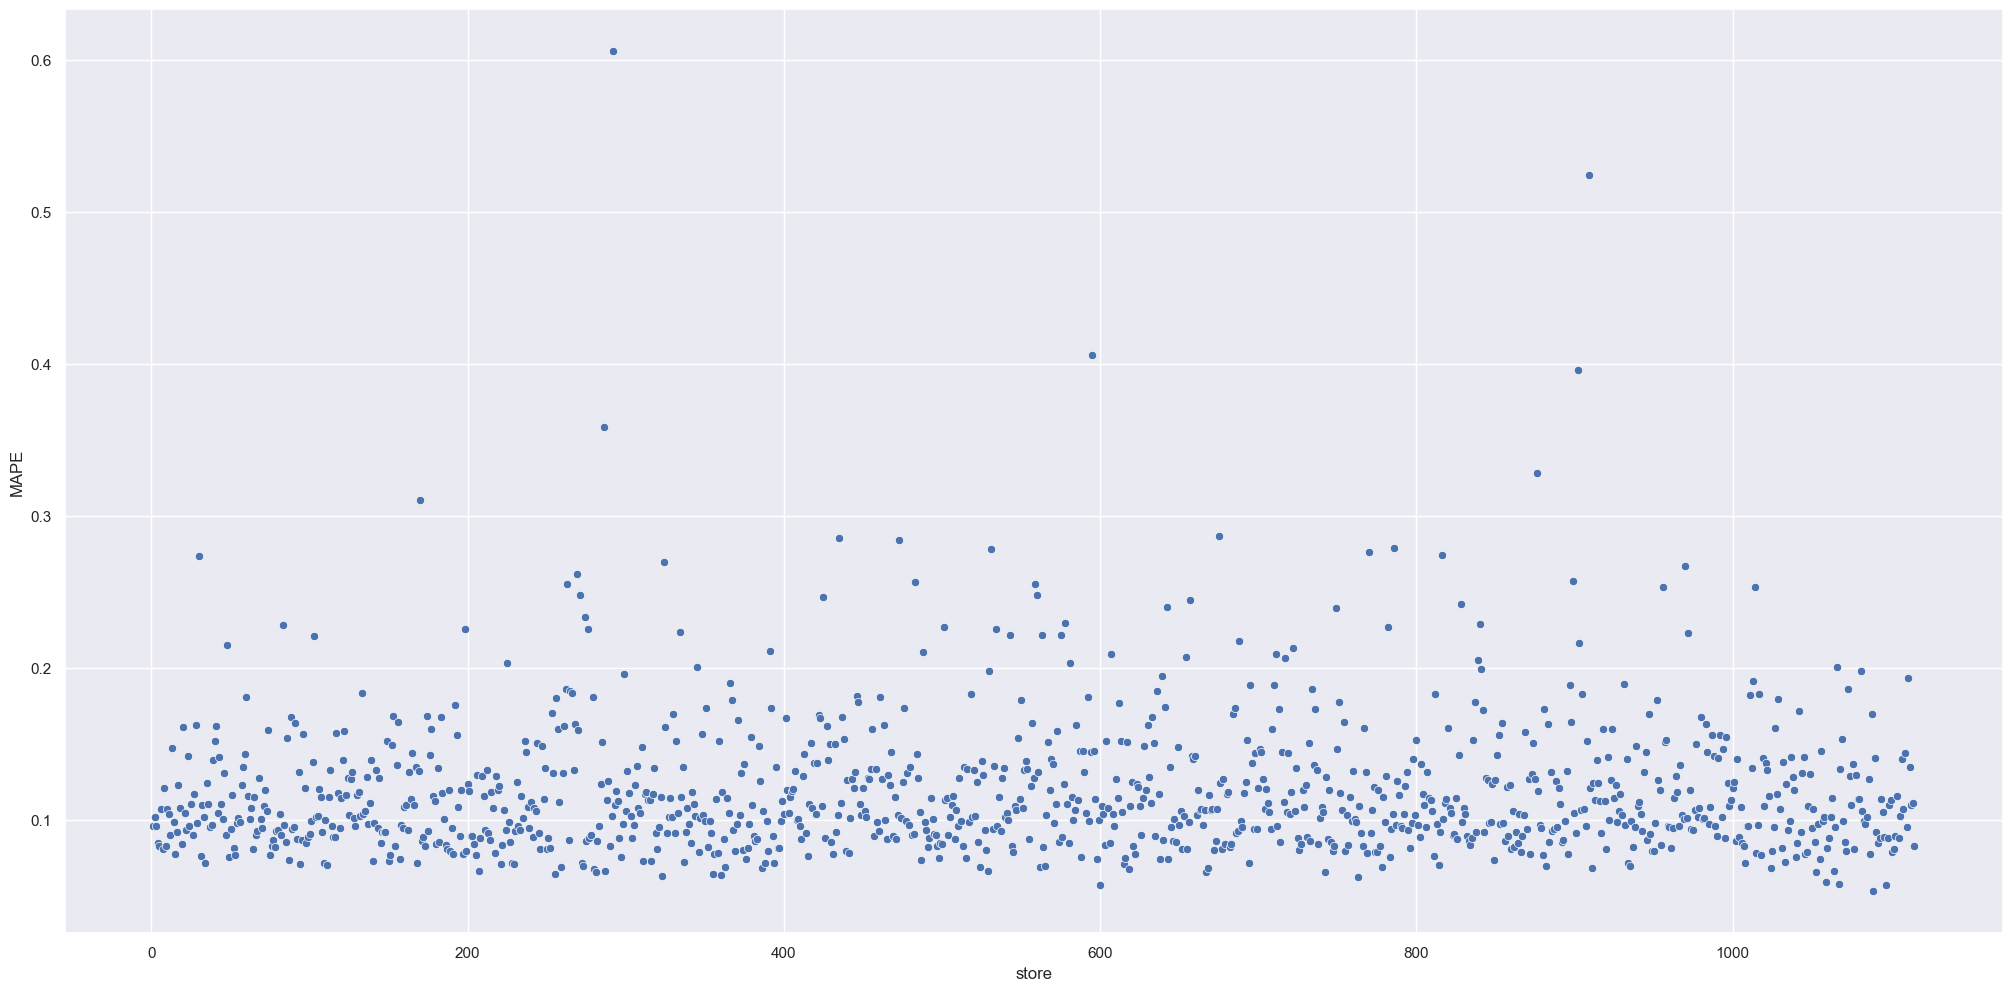

In [112]:
sns.scatterplot(x='store', y='MAPE', data=df92) # forma visual de mostrar esses dados das lojas

## 9.2 - Total Performance

In [103]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename(columns= { 'index' : 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format) # transforma os valores em reais
df93

,Scenarios,Values
0,predictions,"R$288,437,568.00"
1,worst_scenario,"R$287,557,462.83"
2,best_scenario,"R$289,317,669.50"


## 9.3 - Machine Learning Performance (analisa a performance dos aprendizados)

In [113]:
df9['error'] = df9['sales'] - df9['predictions']       # calcula o erro das vendas em relação as predições 
df9['error_rate'] = df9['predictions'] / df9['sales']  # error_rate é a porcentagem das predições em relação as vendas

<Axes: xlabel='predictions', ylabel='error'>

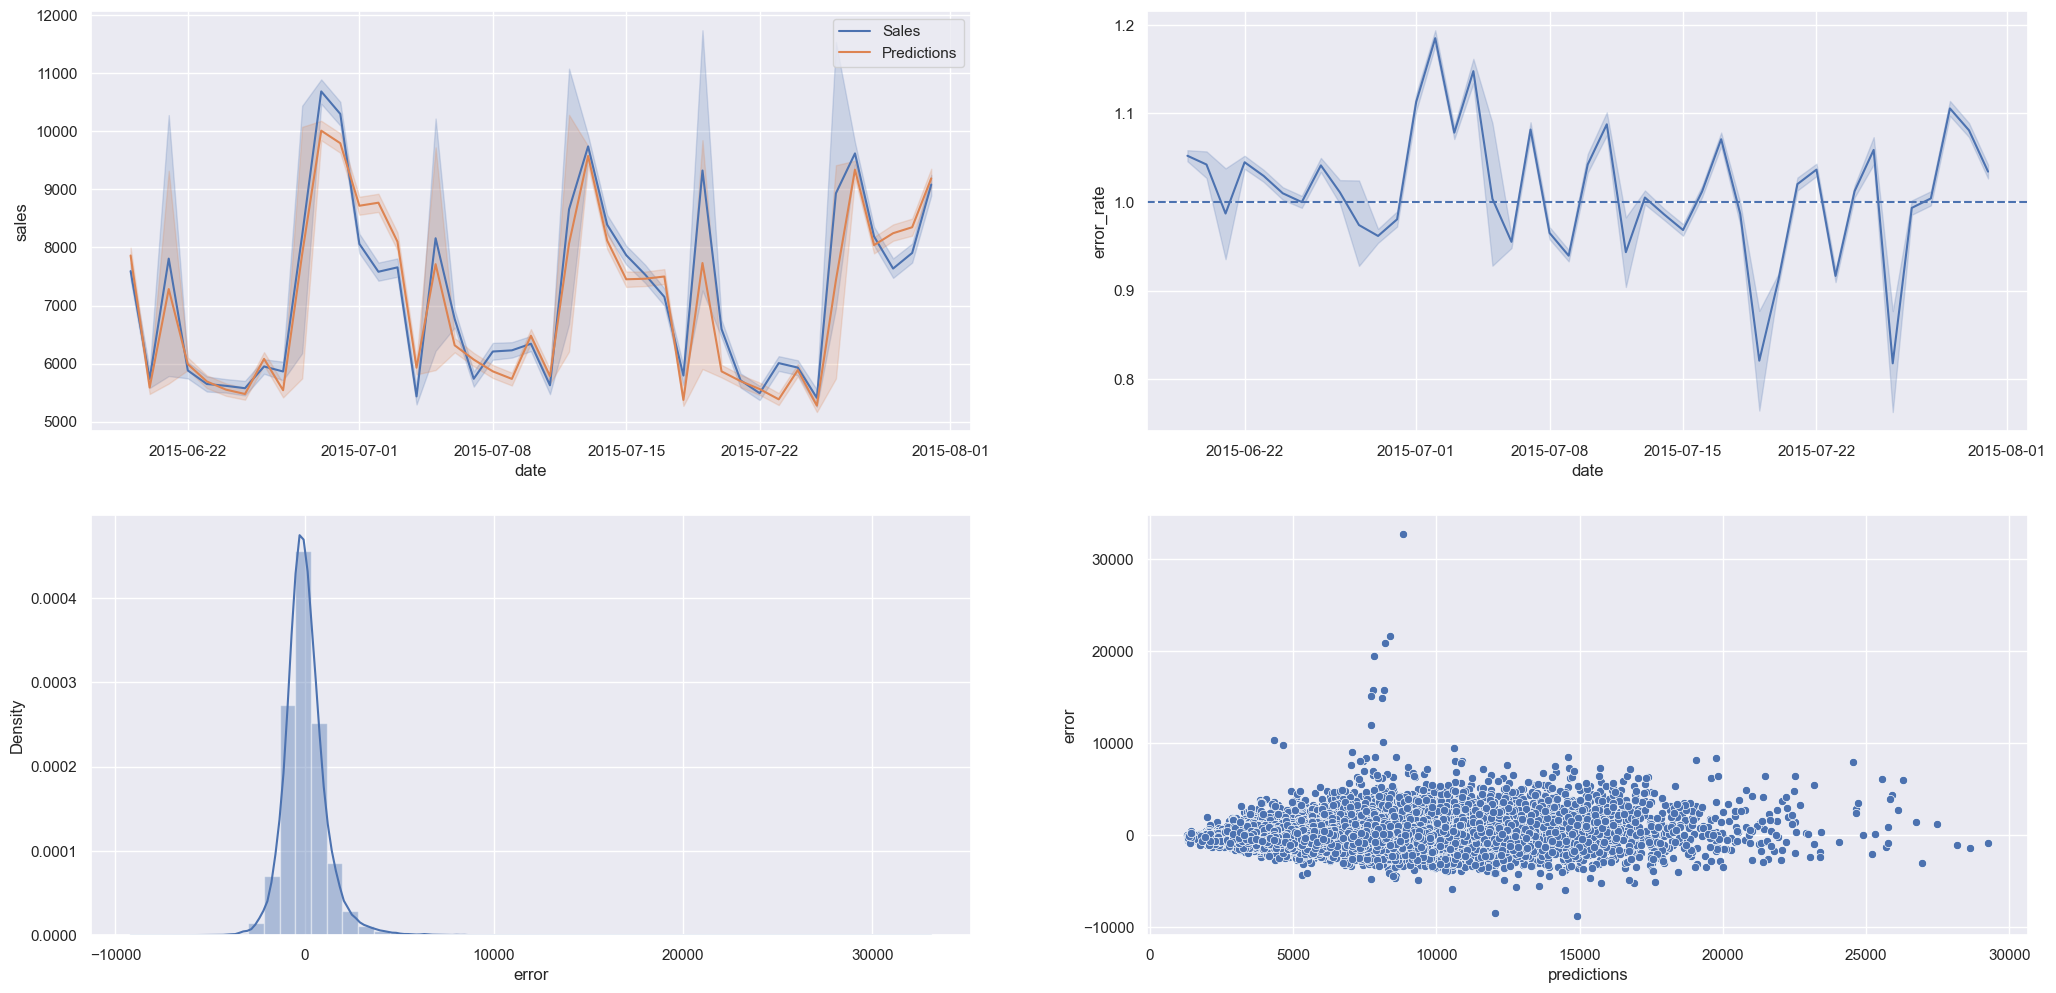

In [114]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label = 'Sales') # label-> legenda
sns.lineplot(x='date', y='predictions', data=df9, label = 'Predictions')
# cria um gráfico de linhas que mostra compara os valores de vendas e predições ao longo das 6 semanas (periodo que foi treinado) e plota tambem uma sombra no grafico que indica a margem de erro


#MPE mean percentage error
plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)# error_rate é a porcentagem das predições em relação as vendas = acima de 1 -> superestimação / abaixo de 1-> subestimação
plt.axhline(1, linestyle = '--') # plota uma linha horizontal no valor 1


plt.subplot(2, 2, 3)
sns.distplot(df9['error']) # distribuição do erro -> nesse caso deu uma distribuição normal (distribuida mais semelhante de forma gaussiana)

plt.subplot(2, 2, 4)
sns.scatterplot(x= df9['predictions'], y=df9['error'])

#distplot e sactterplot é bastante usado para analise de residuo

# 10.0 PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [ ]:
# Saved Trained Model
model_xgb_tuned = pickle.load(open('/data_science/ds_meigarom/ds_em_producao/model/model_rossmann.pkl', 'rb'))

# salvar os parametros, transformações para aplicar nos dados que chegaram via API - (data preparation, rescaling, enconding) passo 5 - data preparation
# (getdumpies, ordinal enconding) feitos no próprio código

## 10.1 - Rossmann Class

In [121]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann (object):
    def __init__(self):
        self.home.path = '/data_science/ds_meigarom/ds_em_producao'
        self.competition_distance_scaler   = pickle.load( open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x) 

        cols_new = list( map(snakecase, cols_old))

        #rename
        df1.columns = cols_new


        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        #competition_distance              
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
        
        #promo_interval                  
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True) 
        df1['month_map'] = df1['date'].dt.month.map(month_map) 
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0  else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis= 1)                                
              
        
        ## 1.6 Change Types
        
        df1.dtypes
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    
    def feature_engineering( self, df2):
        
        #year
        df2['year'] = df2['date'].dt.year.astype('int64')
        
        #month
        df2['month'] = df2['date'].dt.month.astype('int64')
        
        #day
        df2['day'] = df2['date'].dt.day.astype('int64')
        
        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')
        
        #year Week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'] , month =x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')
        
        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/ 7).apply(lambda x: x.days).astype('int64')
                
        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
        
        
        # 3.0 - PASSO 03 (limpeza) - FILTRAGEM DE VARIÁVEIS      
        ## 3.1 - Filtragem das Linhas
        df2 = df2[(df2['open'] != 0) ] 
        
        ## 3.2 - Seleção das colunas
        cols_drop = ['open', 'month_map', 'promo_interval']
        df2 = df2.drop(cols_drop, axis= 1)
        
        return df2
                
        
    def data_preparation(self, df5):
        
        
        ## 5.2 - Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)  # fit_transform encontra os parametros da formula e ja aplica nos dados (localiza os quartis e ja aplica a formula)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        
        ## 5.3 - Transformação
        ### 5.3.1 - Enconding
        # state_holiday - One Hot Enconding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])
        
        
        # store_type - Label Enconding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - Ordinal Enconding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3 - Nature Transformation (variaveis ciclicas)
        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) ) 
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) ) 
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) ) 
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) ) 
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2. * np.pi/12) ) ) 
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2. * np.pi/12) ) ) 
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2. * np.pi/30) ) ) 
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2. * np.pi/30) ) ) 
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month','promo_time_week','day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 
                         'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin']
        
        return df5[cols_selected]
    
    
    def get_prediction( self , model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format= 'iso') 
            

SyntaxError: expected ':' (1965617601.py, line 2)

## 10.2 - API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response # flask - biblioteca com a funções de interação com ambiente web / request - método para pegar o json que será enviado via API

from rosmmann.Rossmann import Rossmann

#loading model
model = pickle.load(open('D:/data_science/ds_meigarom/ds_em_producao/model/model_rossmann.pkl', 'rb')

# initialize API
app = Flask( __name__)

@app.route( '/rossmann/predict' , methods =['POST']) # method ou é post ou get ( post -> envia algum dado para receber, get -> pede alguma coisa)
def rossmann_predict ():
    test_jason = request.get_json()
    
    #teste para saber se o dado realmente foi recebido (true -> existe / false -> não existe / response -> retorna resposta para o código que perguntou
    if test_jason: # there is data
        if isinstance (test_json, dict): # Unique Example
            test_raw = pd.DataFrame( test_jason, index =[0]) # funciona se o test_json for uma unica linha
        
        else: # Multiple Example
            test_raw = pd.DataFrame( test_jason, columns = test_json[0].keys())  # usado quando tem varios json concatenados e quer converter todos eles 
        
        # aplicar todas as limpezas e transformações definidas no Rossmann Class
        
        #Instantiate Rossmann Class = criar uma cópia
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data praparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3) 
        
        return df_response
    
    else:
        return Response(('{}'), status = 200 , mimetype= 'application/jason') # status -> significa que a requisisao deu certo mas o resultado vazio / mimetype -> indica de onde vem o dado
    
if __name__ == '__main__':
    app.run('0.0.0.0')




## 10.3 - API Tester

In [5]:
# loading test dataset
df10 = pd.read_csv('/data_science/ds_meigarom/ds_em_producao/rossmann-store-sales/test.csv')

In [6]:
import requests

In [52]:
#  merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([35, 20, 29])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()] # '~' pegar todas as lojas diferentes de 0 ou vazio
df_test = df_test.drop('Id', axis=1)


In [53]:
#convert dataframe to json
data = json.dumps(df_test.to_dict (orient='records')) #transforma o df em dicionario para converter em json

In [54]:
# API Call
url = 'https://rossmann-model-test-uhqa.onrender.com/rossmann/predict' # para onde vou enviar o pedido / url gerada no render
header =  {'Content-type': 'application/json'} # indica para API qual tipo de dado ta recebendo
data = data # dado

r = requests.post( url, data=data, headers=header ) # fazer a requisição
print(f'Status Code {r.status_code}')

Status Code 200


In [55]:
d1 = pd.DataFrame( r.json(), columns= r.json()[0].keys())


In [56]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range(len(d2)):
    print(f'Store number {d2.loc[i,"store"]} will sell R${d2.loc[i,"prediction"]:,.2f} in the next 6 weeks')

Store number 20 will sell R$265,013.79 in the next 6 weeks
Store number 29 will sell R$298,480.10 in the next 6 weeks
Store number 35 will sell R$299,895.34 in the next 6 weeks


In [57]:
d2

,store,prediction
0,20,265013.789063
1,29,298480.095215
2,35,299895.337402


In [58]:
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 29, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 2170.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 35, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 7660.0, "CompetitionOpenSinceMonth": 10.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 1, "Promo2SinceWeek": 1.0, "Promo2Si